In [75]:
#Usual Data Science
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

#Configures for Jupyter Notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#Twitter and NLP libraries
import got
import csv
import tweepy
from textblob import TextBlob

##Scraper libraries:
#Datetime
import datetime
from datetime import timedelta, date
#os
import os.path
#AWS S3 libraries
import boto3
#checking if file exists in s3 bucket
import botocore
#saving to bucket
import s3fs

#Tweet Loader
import glob

#Currency API
import json
import urllib
import requests
import json
import re

#Time Series Analysis
from dateutil.relativedelta import relativedelta
sns.set(font_scale=1.5)
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import combinations

from scipy import stats
from statsmodels.tsa.arima_model import ARMA

from sklearn.metrics import r2_score
from sklearn.metrics import r2_score, mean_squared_error

#Cryptocurrency API scraping
import time
import json

/Users/matthias/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [72]:
try:
    import private
    API_KEY = private.API_KEY
    API_SECRET = private.API_SECRET
except:
    import settings
    API_KEY = settings.API_KEY
    API_SECRET = settings.API_SECRET

# Introduction

With this year’s bitcoin boom, cryptocurrency has been regularly making headlines. Cryptocurrencies fluctuate daily by large amounts. Perhaps most notably, some currencies experience massive rises or falls at times, appreciating even by 1000% in a day. 

Given the large volatility, it is possible that part of the reason why price changes is due to user sentiment. Twitter is perhaps one of the best available websites to use for sentiment prediction, as it has a large userbase and accesible API.

This project aims to predict price changes through tweet sentiment analysis, through a multivariate time series model.

###  Data collection and storage <a class="tocSkip">

For this project, it is essential to be able to collect historical tweet data, separated by date. The GOT (Get Old Tweets) Package was used to facilitate this.

The large amounts of API queries required was facilitated through use of AWS servers. Data was collected using EC2 servers, and uploaded into an S3 bucket.

The bulk of pricing data was downloaded from a Kaggle Repository. However, a price-scraping function was built to collect new price data from an API.

### Data Processing <a class="tocSkip">

Tweets were scanned for phrases that indicate spam, such as 'free' - in order to delete tweets that add noise to the true sentiment.

Furthermore, raw tweet data was turned into sentiment data through use of the Textblob library - converting the aggregated daily tweets (typically 1000) from each day into single mean sentiment scores.

### Exploratory Data Analysis <a class="tocSkip">

EDA was performed both on individual tweets, as well as on the daily aggregates of tweets. An elbow curve was also built to calculate the ideal number of tweets to scrape. 1000 tweets were chosen as a trade-off between accuracy and API limitations.

### Modelling <a class="tocSkip">

A VARMAX model was used to model the data.

### Price Prediction <a class="tocSkip">

Functions were built to dynamically update the data, and to output the price prediction or the following day.

### Limitations <a class="tocSkip">

Tweets could only be scraped between 11pm and midnight each day, as the Tweet library only allowed iterating through the tweets sequentially. Furthermore, API limitations meant I chose to simply collect the last 50%

### Future Improvements <a class="tocSkip">

Find a way to scrape more tweets for a more representative spread of the day. Use the Tweepy library instead of the GoT one.

Implement other cryptocurrencies (Ethereum, NEO, etc.)

Make a webpage that outputs the next day's prediction for top cryptocurrencies

### Links: <a class="tocSkip">
Get Old Tweets: https://github.com/Jefferson-Henrique/GetOldTweets-python)

Kaggle cryptocurrency dataset: https://www.kaggle.com/jessevent/all-crypto-currencies

Cryptocurrency API: https://min-api.cryptocompare.com

# Tweet Data Collection and Storage


The following functions allow for the scraping, storing and loading of tweet data.

The scraper function iterates through each day in a date range for a specified currency and tweet count, and saves the data into an s3 bucket. It is able to automatically detect the start date and end date of when the currency was listed - to know what range to seach on for tweets. 

The downloader function downloads the s3 server tweet scrapes locally, to facilitate loading as a dataframe. This proved easier than trying to load the data directly, as there were some limitations with the boto3 and s3fs libraries. The function also checks if the file has been previously downloaded - to improve speed.

The loader function iterates over all of the downloaded daily data for the specified currency, and appends it into a large pandas dataframe.

In [76]:
#Loads tweets one tweet at a time and saves into s3 folder
def crypto_tweet_scraper_s3(currency_symbol, search_query, tweets_per_day, key = API_KEY, secret = API_SECRET, start_date = 'auto', auto_database = 'auto', end_date=date(datetime.datetime.now().year, datetime.datetime.now().month, datetime.datetime.now().day), bucket='crypto-tweets', verbose=1):
        
    #load s3 on boto
    s3 = boto3.resource('s3')
    
    #Automatically and optionally loads currency initial listing date.
    #Opens crypto price database, filters to relevant currency, and filters to the first date of listing
    #Crypto price database must be saved as crypto_markets - downloaded from https://www.kaggle.com/jessevent/all-crypto-currencies
    if start_date == 'auto':
        start_date_string = crypto_markets[crypto_markets['symbol']==currency_symbol].iloc[0,1]
        start_date_dt = datetime.datetime.strptime(start_date_string, '%Y-%m-%d')
        start_date = date(start_date_dt.year, start_date_dt.month, start_date_dt.day)
    
    #Function to create an iterator which gives all the days the scraper will look at
    #https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
    def daterange(start_date, end_date):
        for n in range(int ((end_date - start_date).days)):
            yield start_date + timedelta(n)
    
    #Loops over every day defined in the daterange function.
    for single_date in daterange(start_date, end_date + datetime.timedelta(days=1)):

        year = str(single_date.year)
        month = str(single_date.month)
        day = str(single_date.day)
        #Need to get the next day due to a nuance in the got package which always requires date ranges greater than a day - but the data obtained will be from the dates specified.
        date_plus_1 = single_date - datetime.timedelta(days=1)
        year_plus = str(date_plus_1.year)
        month_plus = str(date_plus_1.month)
        day_plus = str(date_plus_1.day)

        #Create the path on which the data will be saved
        path = 'raw_tweet_data/' + currency_symbol + '/' + str(tweets_per_day) + '/' + str(single_date)

        #Check if that day has already been downloaded on S3 and skips day if it has - https://stackoverflow.com/questions/33842944/check-if-a-key-exists-in-a-bucket-in-s3-using-boto3
        try:
            s3.Object(bucket, path + '.csv').load()
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == "404":
                
                #Prints progress data if specified
                if verbose == 1 or verbose == 2:
                    print 'Scraping ' + str(single_date.year) + '-' + str(single_date.month) + '-' + str(single_date.day) + '...'
                
                #Calls the tweet scraper
                tweetCriteria = got.manager.TweetCriteria().setQuerySearch(search_query).setSince(year_plus+'-'+month_plus+'-'+day_plus).setUntil(year+'-'+month+'-'+day).setMaxTweets(int(tweets_per_day))
                tweets = got.manager.TweetManager.getTweets(tweetCriteria)

                #Create empty lists for DF
                tweet_test = []
                tweet_date = []
                tweet_retweets = []
                tweet_favorites = []
                tweet_username = []
                tweet_id = []
                tweet_geo = []
                tweet_mentions = []
                tweet_hashtags = []
                tweet_permalink = []
                
                #Extract Tweet Data
                for tweet in tweets:
                    #change unicode to string
                    tweet_test.append(tweet.text.encode('ascii','ignore'))
                    tweet_date.append(tweet.date.strftime("%Y-%m-%d"))
                    tweet_retweets.append(tweet.retweets)
                    tweet_favorites.append(tweet.favorites)
                    tweet_username.append(tweet.username)
                    tweet_id.append(tweet.id)
                    tweet_geo.append(tweet.geo)
                    tweet_mentions.append(tweet.mentions)
                    tweet_hashtags.append(tweet.hashtags)
                    tweet_permalink.append(tweet.permalink)


                #Add data to DF
                crypto_df_temp = pd.DataFrame()
                crypto_df_temp['tweets'] = tweet_test
                crypto_df_temp['date'] = tweet_date
                crypto_df_temp['retweets'] = tweet_retweets
                crypto_df_temp['favorites'] = tweet_favorites
                crypto_df_temp['username'] = tweet_username
                crypto_df_temp['id'] = tweet_id
                crypto_df_temp['geo'] = tweet_geo
                crypto_df_temp['mentions'] = tweet_mentions
                crypto_df_temp['hashtags'] = tweet_hashtags
                crypto_df_temp['permalink'] = tweet_permalink

                #fixes index issue
                crypto_df_temp = crypto_df_temp.reset_index()
                crypto_df_temp = crypto_df_temp.drop('index',axis=1)

                #Saves file to s3 bucket using s3fs library - #https://stackoverflow.com/questions/38154040/save-dataframe-to-csv-directly-to-s3-python
                #When the API reaches its limits, it starts returning empty lists of data. The length checker checks for this and returns an error.
                if len(crypto_df_temp)>int(tweets_per_day)/5:
                    bytes_to_write = crypto_df_temp.to_csv(None).encode()
                    fs = s3fs.S3FileSystem(key=key, secret=secret)
                    with fs.open('s3://' + bucket + '/' + path  + '.csv', 'wb') as f:
                        f.write(bytes_to_write)
                else:
                    print 'Error with API - stopping process'
                    break

                #Prints progress data if specified
                if verbose == 1 or verbose == 2:
                    print 'Succesfully scraped ' + str(single_date.year) + '-' + str(single_date.month) + '-' + str(single_date.day)
            else:
                print 'Error with accessing s3'
        else:
            #Prints whether the scraper is looping through already existing data (which it automatically skips)
            if verbose == 2:
                print 'Already Downloaded ' + str(single_date.year) + '-' + str(single_date.month) + '-' + str(single_date.day)

In [3]:
def tweet_s3_downloader(currency_symbol, tweets_per_day, bucket_name):
    s3 = boto3.resource('s3')
    #Calls the relevant s3 bucket in the appropriate format
    bucket = s3.Bucket(name=bucket_name)
    #Iterates over every object in the relevant path of the bucket
    for key in bucket.objects.filter(Prefix='raw_tweet_data/' + currency_symbol + '/' + str(tweets_per_day)):
        #Checks if the file has been downloaded previously
        if os.path.isfile(key.key) == False:
            try:
                bucket.download_file(key.key, key.key)
            #If a file couldn't be downloaded, prints error and name of file
            except:
                print 'Error downloading file: ' + key.key
                pass

In [4]:
def tweet_loader(currency_symbol, tweets_per_day):
    currency_symbol = currency_symbol.upper()
    path ='raw_tweet_data/' + currency_symbol + '/' + str(tweets_per_day)
    #Loads all files in a specified path
    allFiles = glob.glob(path + "/*")
    frame = pd.DataFrame()
    list_ = []
    #Iterates over all files
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None)
        list_.append(df)
    #Merges all files together in a DF
    frame = pd.concat(list_)
    frame.drop('Unnamed: 0',axis=1, inplace=True)
    return frame

### Example Use

In [4]:
crypto_tweet_scraper_s3('BTC', 'bitcoin', 1000, start_date = date(2017,11,25), end_date = date(2017,11,28), verbose=2)

Already Downloaded 2017-11-25
Already Downloaded 2017-11-26
Already Downloaded 2017-11-27
Already Downloaded 2017-11-28


In [233]:
tweet_s3_downloader('BTC', '1000', 'crypto-tweets')

In [191]:
crypto_df = tweet_loader('BTC',1000)

In [193]:
crypto_df.shape

(125042, 10)

# Data Cleaning - Raw Tweet Data

As sentiment analysis will be performed on the tweets, it is imperative that 'spam' tweets and noise is removed. For example, there are many tweets that advertise free cryptocurrency for participating in surveys or scams. Ideally, only true opinions will be represented in the data

In [18]:
def tweet_cleaner(df,symbol):
    df.fillna('0', inplace=True)
    #Tweet Cleaning
    df = df.reset_index()
    df['tweets'] = df['tweets'][df['tweets'].str.contains('free', case=False)==False]
    df['tweets'] = df['tweets'][df['tweets'].str.contains('#passiveincome', case=False)==False]
    #Clean tweets mentioning bitcoin forks(that aren't bitcoin anymore) if searching for bitcoin.
    if symbol=='BTC':
        df['tweets'] = df['tweets'][df['tweets'].str.contains('bitcoin cash', case=False)==False]
        df['tweets'] = df['tweets'][df['tweets'].str.contains('bitcoin gold', case=False)==False]
    df['tweets'].drop_duplicates()
    df.dropna(inplace=True)
    df = df.reset_index()
    df = df.drop('index',axis=1)
    return df

In [136]:
# Is there a way to remove duplicates - but not even leave the first/last ones? 
# As they are bound to be spam

### Example Use

In [202]:
crypto_df_cleaned = tweet_cleaner(crypto_df, 'BTC')

In [204]:
crypto_df.shape

(356048, 10)

In [203]:
crypto_df_cleaned.shape

(340149, 11)

# Sentiment Analysis

The TextBlob package is used to assign sentiment scores to each tweet. Each tweet is assigned two ratings - Polarity and Subjectivity. Polarity is the traditional sentiment rating from -1 to 1, which measures the degree to which a user is expressing a positive or negative message. The subjectivity rating measures how opinionated the tweet is.

The function then aggregates these scores for each day - outputting a dataframe of scores for each date. 

In [19]:
def sentiment_mean_both(crypto_df, tweets_per_day):
    
    tweet_polarity = []
    tweet_subjectivity = []
    
    #Sentiment analysis for each tweet
    for tweet in crypto_df['tweets']:
        analysis = TextBlob(tweet)
        tweet_polarity.append(analysis.sentiment.polarity)
        tweet_subjectivity.append(analysis.sentiment.subjectivity)
    
    #Create sentiment columns on the inserted DF
    crypto_df['polarity'] = tweet_polarity
    crypto_df['subjectivity'] = tweet_subjectivity

    #Average the sentiment analysis and other data for each day
    grouped_df = crypto_df.groupby('date')
    mean_df = pd.DataFrame()

    #Create empty columns for new DF of aggregated data
    date_list = []
    polarity_means = []
    subjectivity_means = []
    favorite_means = []
    retweet_means = []

    #Append the data for each day into the new DF
    for n in grouped_df:
        '''
        Some of the scraped data was not scraped properly - EDA showed that 4 or 5 of the dates only had 1 or 2 data points.
        Setting an if condition with this range allows for small inconsistencies in the scraper and for the cleaning of spam,
        while ensuring that no large anomalies (<50% of data or >130%) are inserted.
        '''
        if (len(n[1]['polarity']) >= int(tweets_per_day)/2.0) & (len(n[1]['polarity']) <= (int(tweets_per_day) * 1.3)):
            date_list.append(n[0])
            polarity_means.append(np.mean(n[1]['polarity']))
            subjectivity_means.append(np.mean(n[1]['subjectivity']))
            '''
            A cap of 10 was placed in mean and retweet scores, because a single tweet with, for example 12,000 favorites,
            had massive effects on the mean scores. This way the impact of a popular tweet is reflected without completely skewing the data
            '''
            if np.mean(n[1]['favorites'])<= 10:
                favorite_means.append(np.mean(n[1]['favorites']))
            else:
                favorite_means.append(float(10))
            if np.mean(n[1]['retweets']) <= 10:
                retweet_means.append(np.mean(n[1]['retweets']))
            else:
                retweet_means.append(float(10))

    mean_df['date'] = date_list
    mean_df['polarity'] = polarity_means
    mean_df['subjectivity'] = subjectivity_means
    mean_df['favorites'] = favorite_means
    mean_df['retweets'] = retweet_means
    
    return mean_df

### Example Use

In [207]:
mean_df = sentiment_mean_both(crypto_df, 1000)
mean_df.head()

date  polarity  subjectivity
0  2013-04-27  0.101307      0.243508
1  2013-04-28  0.142292      0.207251
2  2013-04-29  0.109972      0.269425
3  2013-04-30  0.127239      0.251784
4  2013-05-01  0.078049      0.193171

# Price Data Integration

A kaggle cryptocurrency price dataset is used for training the model (https://www.kaggle.com/jessevent/all-crypto-currencies). This has data up to December 15th, 2017.

For prediction purposes further in the project, the cryptocompare api will be used (https://min-api.cryptocompare.com), allowing collection of current price data.

This section implements a function that adds cryptocurrency price data to the dataframe, merging with sentiment data through an inner join. 


In [21]:
crypto_markets = pd.read_csv('crypto_markets.csv')

def price_merger(symbol, mean_df, market_data):
    #performs an inner join for date between mean_df and price data on that currency
    price_df = market_data[market_data['symbol']==symbol]
    
    price_df = price_df[['close','date']]
    price_df = price_df.rename(columns={'close':'price'})

    merged_df = pd.merge(mean_df,price_df,on='date')
    merged_df = merged_df.set_index('date')
    
    return merged_df

### Example Use

In [ ]:
merge_df = price_merger('BTC', mean_df, crypto_markets)

# Consolidate cleaning functions

These steps will have to be performed multiple times; Consolidating them allows storing all of the data cleaning in one function. 


In [20]:
def clean_raw_data(df, symbol, market_data, tweets_per_day):
    #Takes raw data and transforms it into cleaned data
    
    #Function to delete spam tweets
    df = tweet_cleaner(df, symbol)
    df.reset_index()
    #Function to perform sentiment analysis and aggregate tweets
    mean_df = sentiment_mean_both(df, int(tweets_per_day))
    #Function to append cryptocurrency data
    merged_df = price_merger(symbol, mean_df, market_data)
    return merged_df

### Example Use

In [ ]:
clean_raw_data(crypto_df_2, 'BTC', crypto_markets)

# Exploratory Data Analysis - Raw Data

## CaIculating Ideal Scraping Amount

Scraping tweets will be computationally expensive, as daily tweets will have to be scraped over the lifetime of a cryptocurrency. However, a small amount of tweets may result in inaccurate data. Thus, an 'elbow curve' can show the minimum number of tweets in which representative mean data can be acquired.

In [ ]:
value_list = [100,250,500,750,1000,1500]
month_list = [3,4,5,6,7]
elbow_dict = {}

#Iterates over 5 different months (to get some variation in data) for several values of tweets, creating a dictionary with the information
for month in month_list:
    polarity_list = []
    subjectivity_list = []
    for value in value_list:
        value = str(value)
        crypto_tweet_scraper_s3('BTC', 'bitcoin', value, start_date = date(2017,month,27), end_date = date(2017,month,27), verbose=2)
        tweet_s3_downloader('BTC', value, 'crypto-tweets')
        crypto_df = pd.read_csv('raw_tweet_data/BTC/' + value + '/2017-0' + str(month) + '-27.csv')
        crypto_df = tweet_cleaner(crypto_df, 'BTC')
        mean_df_temp = sentiment_mean_both(crypto_df)
        polarity_list.append(mean_df_temp['polarity'].values[0])
        subjectivity_list.append(mean_df_temp['subjectivity'].values[0])
    
    elbow_df = pd.DataFrame()
    elbow_df['tweets'] = value_list
    elbow_df['polarity'] = polarity_list
    elbow_df['subjectivity'] = subjectivity_list
    elbow_dict[month] = elbow_df

Observing the data below, I can tell that the score converges as the number of tweets increases. 3 of the 5 tests stabilie at 1000 tweets, while the other two still fluctuate somewhat. This experiment chose to scrape 1000 tweets per day, as a tradeoff between accuracy and scraping limitations - as the Tweeter API limit made it difficult to obtain more data.

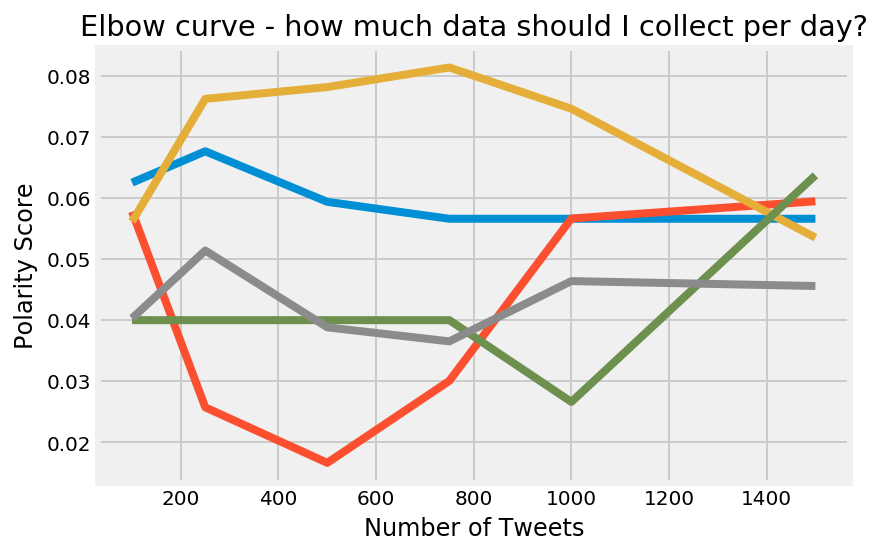

In [34]:
for n in month_list:
    plt.plot(elbow_dict[n]['tweets'],elbow_dict[n]['polarity'])
    plt.title('Elbow curve - how much data should I collect per day?')
    plt.xlabel('Number of Tweets')
    plt.ylabel('Polarity Score')

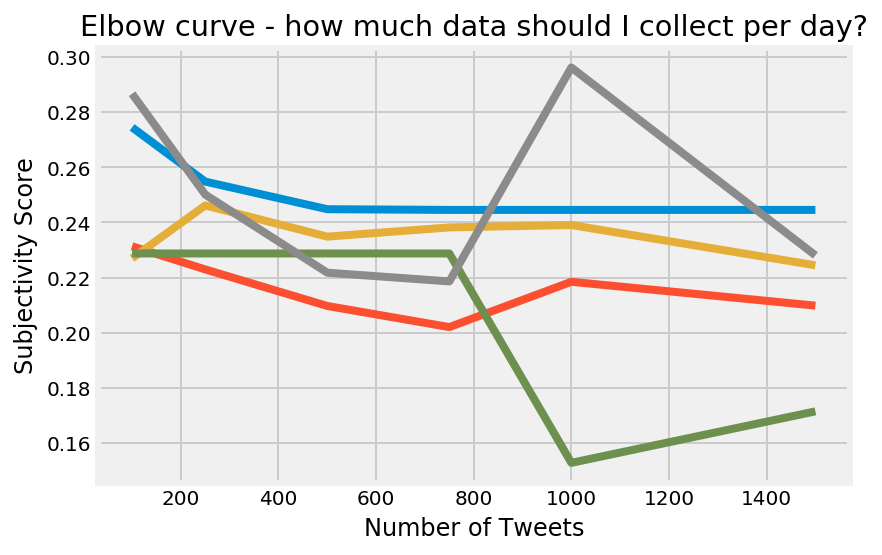

In [45]:
for n in month_list:
    plt.plot(elbow_dict[n]['tweets'],elbow_dict[n]['subjectivity'])
    plt.title('Elbow curve - how much data should I collect per day?')
    plt.xlabel('Number of Tweets')
    plt.ylabel('Subjectivity Score')

Looking at the overall distribution - the scores do vary by a significant amount. However, this is a trade-off the model will have to have.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ebddf10>]], dtype=object)

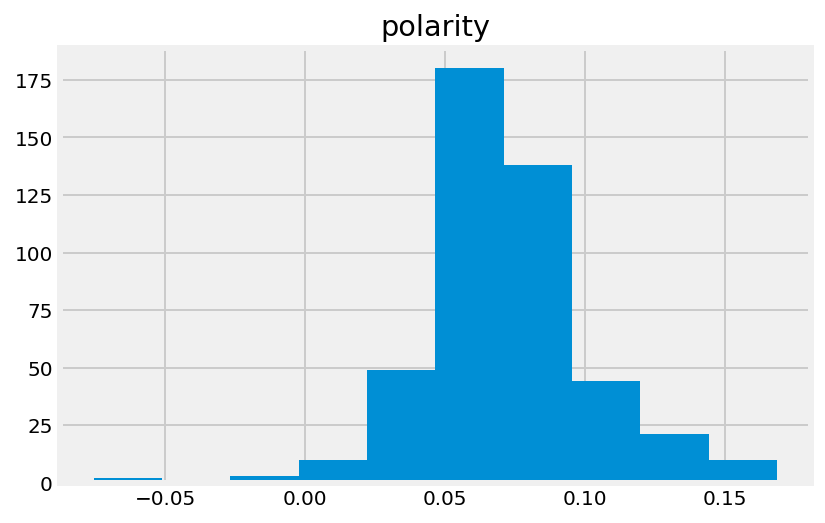

In [44]:
mean_scores = pd.read_csv('full_agg_2017-01-09')
mean_scores.hist('polarity')

## Integrating Sentiment Scores

A variation of the sentiment aggregator function is used to observe the effect on individual tweets. This will be useful as it will allow seeing the typical distribution of tweets, and whether there is any skew. It also allows analysis of the impacts of other aspects of the data, such as number of retweets.

In [22]:
def sentiment_analysis(crypto_df):
    #Sentiment analysis for each tweet
    tweet_polarity = []
    tweet_subjectivity = []
    for tweet in crypto_df['tweets']:
        analysis = TextBlob(tweet)
        tweet_polarity.append(analysis.sentiment.polarity)
        tweet_subjectivity.append(analysis.sentiment.subjectivity)
    crypto_df['polarity'] = tweet_polarity
    crypto_df['subjectivity'] = tweet_subjectivity
    return crypto_df

In [115]:
df = tweet_loader('BTC', 1000)
crypto_df = tweet_cleaner(df, 'BTC')
sent_df = sentiment_analysis(crypto_df)

In [117]:
sent_df.to_csv('sentiment_df_2017-01-09')

## Individual Categories Analysis:

This tweet dataframe consists of date, tweets, retweets, favorites, username, id, mentions, hashtags, permalink, polarity and subjectivity.

Tweets and hashtags are no longer needed as the sentiment scores account for them.
Username, id, mentions, and permalink do not provide any useful information either.

We are thus left with our sentiment scores (polarity and subjectivity), as well as retweets and favorites.

In [181]:
sent_df.shape

(444378, 13)

In [ ]:
sent_df.drop(['level_0','geo'],axis=1,inplace=True)

In [332]:
sent_df.head(2).set_index('date')

tweets  retweets  \
date                                                                      
2013-12-10  Checking in at the MGM grand for the inside bi...         0   
2013-12-10  [E1] Get REAL with Jan Skoyles - Gold, Silver ...         0   

            favorites         username                  id       mentions  \
date                                                                        
2013-12-10          0       CLYMONcrew  410559468330434560  @MGMVideowall   
2013-12-10          1  carlosgongoracg  410559466963087360      @Skoylesy   

                             hashtags  \
date                                    
2013-12-10  #bitcoin #CLYMON #RIPFRED   
2013-12-10                          0   

                                                    permalink  polarity  \
date                                                                      
2013-12-10  https://twitter.com/CLYMONcrew/status/41055946...       0.5   
2013-12-10  https://twitter.com/carlosgongoracg/status/410...       0.2   

            subjectivity  
date                      
2013-12-10           1.0  
2013-12-10           0.3

As could probably be expected, favorites are highly correlated to retweets (0.656). Additionally, subjectivity is correlated to polarity (0.325). There is no other significant correlation between the variables, sugesting that favorites and retweets are not significant indicators of sentiment.

In [361]:
sent_df.loc[:,['polarity','subjectivity','favorites','retweets']].corr()

polarity  subjectivity  favorites  retweets
polarity      1.000000      0.325266   0.002090  0.002911
subjectivity  0.325266      1.000000   0.002373  0.000988
favorites     0.002090      0.002373   1.000000  0.656208
retweets      0.002911      0.000988   0.656208  1.000000

### Sentiment: Polarity and Subjectivity

The textblob NLP tool provides polarity scores from -1.0 to 1.0 and subjectivity scores from 0 to 1. The histogram below shows that a large amount of tweets are neutral in either polarity or subjectivity. Additional calculation shows that 58% of polarity scores are 0, and 50% of subjectivity scores are 0. It is thus a relatively small majority that determine the mean score.

% of polarity scores equaling 0:  0.577629855663
% of sentiment scores equaling 0:  0.503325997237


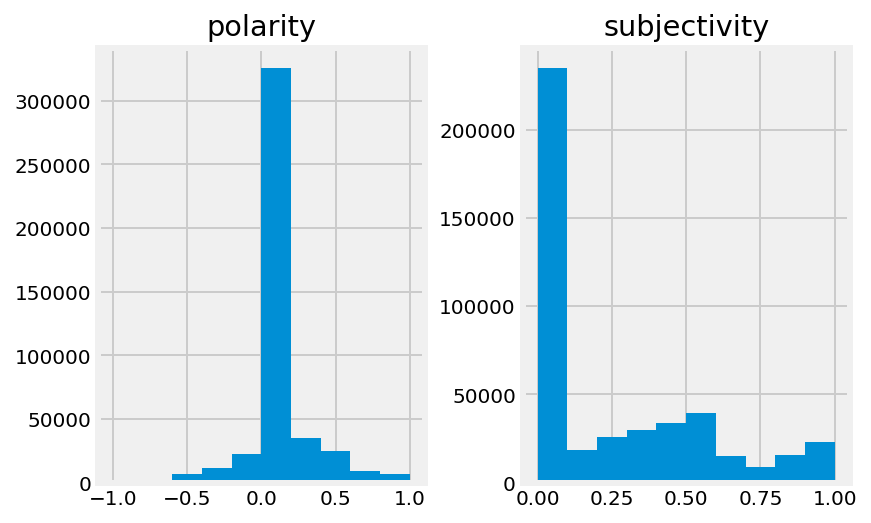

In [210]:
sent_df.loc[:,['polarity','subjectivity']].hist(bins=10)

output = float((sent_df['polarity']==0).sum())/len(sent_df['polarity'])
print '% of polarity scores equaling 0: ', output

output = float((sent_df['subjectivity']==0).sum())/len(sent_df['subjectivity'])
print '% of sentiment scores equaling 0: ', output

Sentiment score distribution does not change much between 2013 and 2017 - but the average polarity and subjectivity does decrease by about 0.02. Perhaps as bitcoin gained in popularity, more skepticism occured - leading to the lower polarity score.

2013 polarity:  0.0820199879194  subjectivity:  0.253630582375
2017 polarity:  0.0625277514845  subjectivity:  0.229879402538


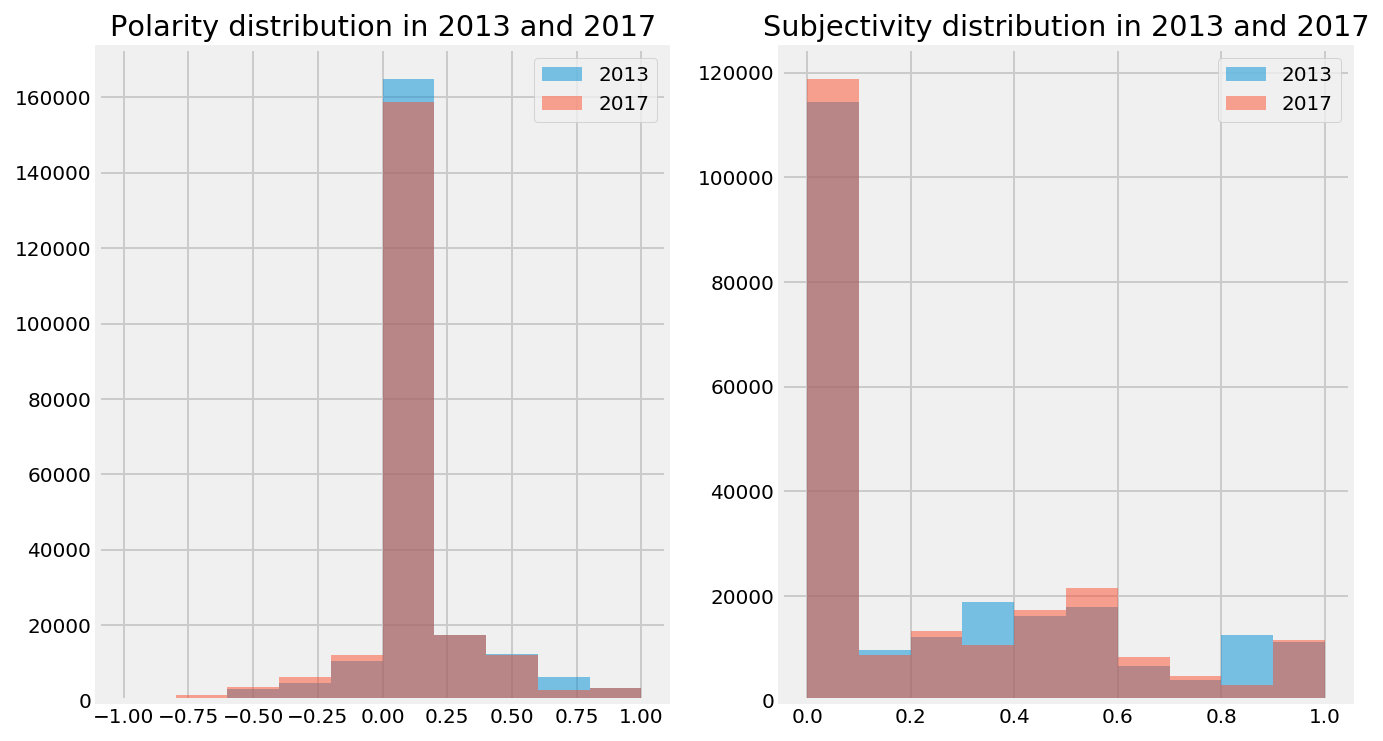

In [266]:
#Plot Histograms under subplots
fig, (ax,ax1) = plt.subplots(ncols=2, figsize=(10,6))
x = sent_df['polarity'][sent_df['date'].str.contains('2013')]
y = sent_df['polarity'][sent_df['date'].str.contains('2017')]

ax.hist(x, alpha=0.5, label='2013')
ax.hist(y, alpha=0.5, label='2017')
ax.set_title('Polarity distribution in 2013 and 2017')
ax.legend(loc='upper right')

x = sent_df['subjectivity'][sent_df['date'].str.contains('2013')]
y = sent_df['subjectivity'][sent_df['date'].str.contains('2017')]

ax1.hist(x, alpha=0.5, label='2013')
ax1.hist(y, alpha=0.5, label='2017')
ax1.set_title('Subjectivity distribution in 2013 and 2017')
ax1.legend(loc='upper right')

#Print Mean Scores
mean_2013 = sent_df.loc[:,['polarity','subjectivity']][sent_df['date'].str.contains('2013')].mean()
mean_2017 = sent_df.loc[:,['polarity','subjectivity']][sent_df['date'].str.contains('2017')].mean()
print '2013 polarity: ', mean_2013[0],' subjectivity: ', mean_2013[1]
print '2017 polarity: ', mean_2017[0],' subjectivity: ', mean_2017[1]

### Favorites

Most tweets - 81%, receive no favorites. 12% receive 1 favorite, and percentages drop significantly, only 3% receiving 2 favorites. Only 6 tweets received over 5,000 favorites, with the highest received 12,407.

0 Favorites Percentage: 0.808707901831
1 Favorites Percentage: 0.118815512919
2 Favorites Percentage: 0.0297134421596
3 Favorites Percentage: 0.0119560374276
4 Favorites Percentage: 0.0064404628492


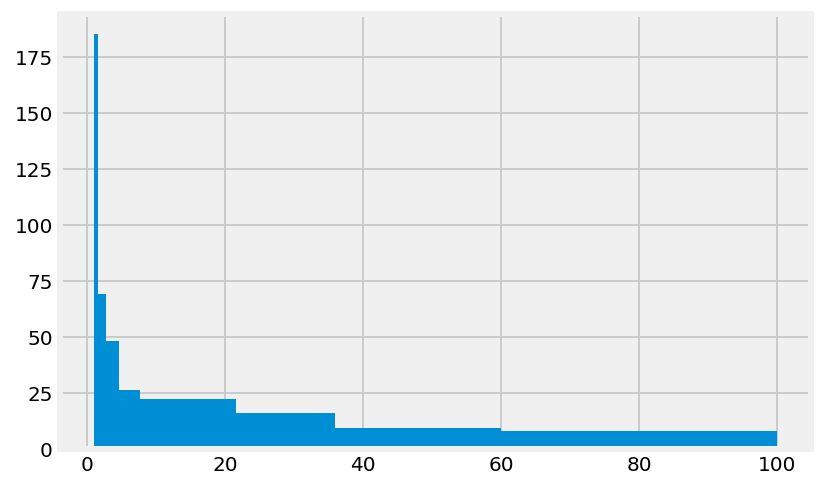

In [310]:
print '0 Favorites Percentage:', float((sent_df['favorites']==0).sum())/len(sent_df['favorites'])
print '1 Favorites Percentage:', float((sent_df['favorites']==1).sum())/len(sent_df['favorites'])
print '2 Favorites Percentage:', float((sent_df['favorites']==2).sum())/len(sent_df['favorites'])
print '3 Favorites Percentage:', float((sent_df['favorites']==3).sum())/len(sent_df['favorites'])
print '4 Favorites Percentage:', float((sent_df['favorites']==4).sum())/len(sent_df['favorites'])

sent_df['favorites'].value_counts().hist(bins=np.logspace(0,2,10))

Mean polarity and subjectivity are greater in popular tweets (>500), but not by a large margin.

In [348]:
print 'Mean polarity for Tweets > 500: ', sent_df['polarity'][sent_df['favorites']>500].mean(), '  Mean subjectivity for Tweets > 500: ', sent_df['subjectivity'][sent_df['favorites']>500].mean()
print 'Mean polarity for Tweets < 500: ', sent_df['polarity'][sent_df['favorites']<500].mean(), '  Mean subjectivity for Tweets < 500: ', sent_df['subjectivity'][sent_df['favorites']<500].mean()

Mean polarity for Tweets > 500:  0.0971385471254   Mean subjectivity for Tweets > 500:  0.253903432824
Mean polarity for Tweets < 500:  0.0724272239195   Mean subjectivity for Tweets < 500:  0.241884790401


Observing the most popular tweets, none seem to be ones that could help predict sentiment. They don't follow a pattern other than sometimes being by famous people (For example, Julian Assange).

In [349]:
sent_df[sent_df['favorites']>3000].drop_duplicates('tweets').set_index('date')

tweets  retweets  \
date                                                                      
2017-08-22  Kyk borcunu babasna deten adam " bitcoin almal...       393   
2017-08-06  If Bitcoin was a City. pic.twitter.com/jNBuWR7JAB      6861   
2017-08-20  DetectorToken is live with 25% BONUS! https://...      4864   
2016-10-12  Boost Your Career in FinTech with the World's ...      3103   
2017-12-20  I'm back! #myfirstTweet #blockchain #cryptocur...     15457   
2017-07-14  I coulda bought some Bitcoin before it was Bit...      4406   
2017-11-30  Bitch wont take bit coin what da fuck pic.twit...      2498   
2017-10-14  If you invested $10,000 in Bitcoin 7 years ago...      2061   
2017-12-12            Does anyone REALLY understand bitcoin ?      2059   
2017-08-03  If you bought $100 worth of Bitcoin 7 years ag...      2308   
2017-11-19  #Bitcoin hits $8000 USD. pic.twitter.com/awGSL...      1388   
2017-08-01  According to #btce 's statement, databases and...      5467   

            favorites        username                  id mentions  \
date                                                                 
2017-08-22       4754     Overlokcu12  899782305077743617        0   
2017-08-06      12407    BTCarchitect  894297209537277957        0   
2017-08-20       3522   DetectorToken  899048293476556800        0   
2016-10-12      10269      MScDigital  786085410178949120        0   
2017-12-20       4692    Top500Crypto  943629624696885248        0   
2017-07-14       6417        DOEDoobs  885838120478007296        0   
2017-11-30       5874  hondadeal4vets  936382923246157825        0   
2017-10-14       4224       KimDotcom  918981186021572608        0   
2017-12-12      10087            norm  940731645195272192        0   
2017-08-03       5385       UberFacts  892886982434619392        0   
2017-11-19       3088   JulianAssange  932390634626920450        0   
2017-08-01       4479     willyclicks  892171560823517184     @FBI   

                                                     hashtags  \
date                                                            
2017-08-22                                                  0   
2017-08-06                                                  0   
2017-08-20  #ICO #CRYPTOCURRENCY #ETHEREUM #BITCOIN #ETH #...   
2016-10-12                                                 #1   
2017-12-20  #myfirstTweet #blockchain #cryptocurrency #Bit...   
2017-07-14                                                  0   
2017-11-30                                                  0   
2017-10-14                                                  0   
2017-12-12                                                  0   
2017-08-03                                                  0   
2017-11-19                                           #Bitcoin   
2017-08-01                                     #btce #bitcoin   

                                                    permalink  polarity  \
date                                                                      
2017-08-22  https://twitter.com/Overlokcu12/status/8997823...  0.000000   
2017-08-06  https://twitter.com/BTCarchitect/status/894297...  0.000000   
2017-08-20  https://twitter.com/DetectorToken/status/89904...  0.170455   
2016-10-12  https://twitter.com/MScDigital/status/78608541...  0.000000   
2017-12-20  https://twitter.com/Top500Crypto/status/943629...  0.194444   
2017-07-14  https://twitter.com/DOEDoobs/status/8858381204...  0.150000   
2017-11-30  https://twitter.com/hondadeal4vets/status/9363... -0.400000   
2017-10-14  https://twitter.com/KimDotcom/status/918981186...  0.300000   
2017-12-12  https://twitter.com/norm/status/94073164519527...  0.200000   
2017-08-03  https://twitter.com/UberFacts/status/892886982...  0.292857   
2017-11-19  https://twitter.com/JulianAssange/status/93239...  0.000000   
2017-08-01  https://twitter.com/willyclicks/status/8921715...  0.000000   

            subjectivity  
date                      
2017-08

### Retweets

Like favorites, most posts have 0 retweets, and the number drops down rapily after 1 retweet.

0 Retweets Percentage: 0.800737210213
1 Retweets Percentage: 0.115349994824
2 Retweets Percentage: 0.038737291225
3 Retweets Percentage: 0.0164049525404
4 Retweets Percentage: 0.00756563106184


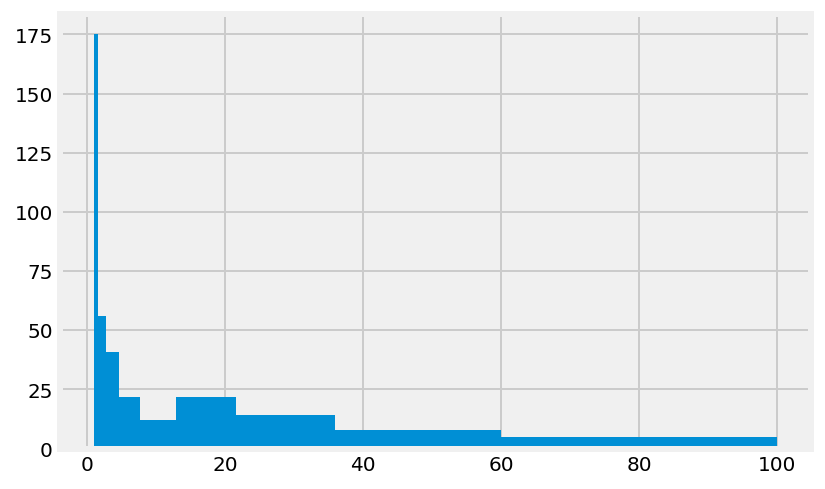

In [351]:
print '0 Retweets Percentage:', float((sent_df['retweets']==0).sum())/len(sent_df['retweets'])
print '1 Retweets Percentage:', float((sent_df['retweets']==1).sum())/len(sent_df['retweets'])
print '2 Retweets Percentage:', float((sent_df['retweets']==2).sum())/len(sent_df['retweets'])
print '3 Retweets Percentage:', float((sent_df['retweets']==3).sum())/len(sent_df['retweets'])
print '4 Retweets Percentage:', float((sent_df['retweets']==4).sum())/len(sent_df['retweets'])

sent_df['retweets'].value_counts().hist(bins=np.logspace(0,2,10))

There is an increase in polarity and subjectivity when retweets are greater than 50. This could indicate that positive messages are more likely to propagate than negative ones.

In [365]:
print 'Mean polarity for Tweets > 50: ', sent_df['polarity'][sent_df['retweets']>50].mean(), '  Mean subjectivity for Tweets > 50: ', sent_df['subjectivity'][sent_df['retweets']>50].mean()
print 'Mean polarity for Tweets < 50: ', sent_df['polarity'][sent_df['retweets']<50].mean(), '  Mean subjectivity for Tweets < 50: ', sent_df['subjectivity'][sent_df['retweets']<50].mean()

Mean polarity for Tweets > 50:  0.113531656191   Mean subjectivity for Tweets > 50:  0.3043224807
Mean polarity for Tweets < 50:  0.0723372085775   Mean subjectivity for Tweets < 50:  0.241742740895


The most retweeted tweets have a large overlap with favorites. There is not a large discernible pattern, although tweets do seem to have a better sentiment.

In [358]:
sent_df[sent_df['retweets']>3000].drop_duplicates('tweets').set_index('date')

tweets  retweets  \
date                                                                      
2017-03-10  BREAKING NEWS: SEC banned Bitcoin ! Bitcoin CE...      3200   
2017-11-11  You are looking for a Xmas present? a present ...      3646   
2017-03-15  The opportunities with Bitcoin are amazing. Yo...      4863   
2017-08-06  If Bitcoin was a City. pic.twitter.com/jNBuWR7JAB      6861   
2017-08-20  DetectorToken is live with 25% BONUS! https://...      4864   
2016-10-12  Boost Your Career in FinTech with the World's ...      3103   
2017-12-20  I'm back! #myfirstTweet #blockchain #cryptocur...     15457   
2017-07-14  I coulda bought some Bitcoin before it was Bit...      4406   
2017-09-08  USI-Tech Terms and Conditions (Updated 9-8-201...      3207   
2017-06-29  " Bitcoin is better than currency" ~ Bill Gate...      3817   
2017-07-25  FLOODCRM INVITES - Cheap HQ Email Bomber. Subs...      4567   
2017-06-04  Bill Gates says that Bitcoin is better than Cu...      3062   
2017-08-01  According to #btce 's statement, databases and...      5467   

            favorites         username                  id   mentions  \
date                                                                    
2017-03-10        444      willyclicks  840347631276740609  @SEC_News   
2017-11-11         28         SBaensch  929492334433177600          0   
2017-03-15         31    LaurieWeller1  842146599983763457          0   
2017-08-06      12407     BTCarchitect  894297209537277957          0   
2017-08-20       3522    DetectorToken  899048293476556800          0   
2016-10-12      10269       MScDigital  786085410178949120          0   
2017-12-20       4692     Top500Crypto  943629624696885248          0   
2017-07-14       6417         DOEDoobs  885838120478007296          0   
2017-09-08        362   USITechBitcoin  906220438241501184          0   
2017-06-29         30     WayneTrainVN  880389274444509184          0   
2017-07-25       2277  seytaninpabucuu  889627480520364035          0   
2017-06-04         40      amor_wilkes  871143651879116800          0   
2017-08-01       4479      willyclicks  892171560823517184       @FBI   

                                                     hashtags  \
date                                                            
2017-03-10                                                  0   
2017-11-11                                                  0   
2017-03-15                                                  0   
2017-08-06                                                  0   
2017-08-20  #ICO #CRYPTOCURRENCY #ETHEREUM #BITCOIN #ETH #...   
2016-10-12                                                 #1   
2017-12-20  #myfirstTweet #blockchain #cryptocurrency #Bit...   
2017-07-14                                                  0   
2017-09-08                         #bitcoin #automatedprofits   
2017-06-29                                                  0   
2017-07-25                                           #bitcoin   
2017-06-04                                                  0   
2017-08-01                                     #btce #bitcoin   

                                                    permalink  polarity  \
date                                                                      
2017-03-10  https://twitter.com/willyclicks/status/8403476... -0.156250   
2017-11-11  https://twitter.com/SBaensch/status/9294923344...  0.309375   
2017-03-15  https://twitter.com/LaurieWeller1/status/84214...  0.206250   
2017-08-06  https://twitter.com/BTCarchitect/status/894297...  0.000000   
2017-08-20  https://twitter.com/DetectorToken/status/89904...  0.170455   
2016-10-12  https://twitter.com/MScDigital/status/78608541...  0.000000   
2017-12-20  https://twitter.com/Top500Crypto/status/943629...  0.194444   
2017-07-14  https://twitter.com/DOEDoobs/status/8858381204...  0.150000   
2017-09-08  https://twitter.com/USITechBitcoin/status/9062...  0.000000   
2017-06-29  https://twitter.com/

### Outliers

Looking at the massive values single values can amass, it is important to account for those when aggregating each set of 1000 tweets. Thus, the maximum daily score for retweets and favorites was set to 10. This is because a normal day scores around 1-2, and these outliers were causing the average score to rise to values up to 50.

In [63]:
raw_df[raw_df['favorites']>50].sort_values('favorites', ascending=False).drop_duplicates().head(5)

tweets        date  \
96757   If Bitcoin was a City. pic.twitter.com/jNBuWR7JAB  2017-08-06   
139733  Boost Your Career in FinTech with the World's ...  2016-10-12   
322776            Does anyone REALLY understand bitcoin ?  2017-12-12   
166003  I coulda bought some Bitcoin before it was Bit...  2017-07-14   
272188  Bitch wont take bit coin what da fuck pic.twit...  2017-11-30   

        retweets  favorites        username                  id  geo mentions  \
96757       6861      12407    BTCarchitect  894297209537277957    0        0   
139733      3103      10269      MScDigital  786085410178949120    0        0   
322776      2059      10087            norm  940731645195272192    0        0   
166003      4406       6417        DOEDoobs  885838120478007296    0        0   
272188      2498       5874  hondadeal4vets  936382923246157825    0        0   

       hashtags                                          permalink  polarity  \
96757         0  https://twitter.com/BTCarchitect/status/894297...      0.00   
139733       #1  https://twitter.com/MScDigital/status/78608541...      0.00   
322776        0  https://twitter.com/norm/status/94073164519527...      0.20   
166003        0  https://twitter.com/DOEDoobs/status/8858381204...      0.15   
272188        0  https://twitter.com/hondadeal4vets/status/9363...     -0.40   

        subjectivity  
96757         0.0000  
139733        0.0000  
322776        0.2000  
166003        0.1125  
272188        0.6000

# Exploratory Data Analysis - Aggregated Data

In [11]:
crypto_markets = pd.read_csv('crypto_markets.csv')

In [16]:
raw_df = tweet_loader('BTC',1000)

In [17]:
raw_df = pd.read_csv('sentiment_df_2017-01-09')

In [18]:
raw_df.drop(['Unnamed: 0','level_0'],axis=1,inplace=True)

In [ ]:
c_df = clean_raw_data(raw_df, 'BTC', crypto_markets, 1000)

In [ ]:
c_df.head(3)

In [ ]:
c_df.to_csv('cleaned_data_2017-01-13')

In [13]:
c_df = pd.read_csv('cleaned_data_2017-01-13').set_index('date')

## Observing the Correlation Matrix

As this is time-series data and variables are dependent, correlations betwen variables can be further observed by looking at time-lagged correlations. However, single-day correlations will be observed first.

Very interestingly, the correlation between price, polarity and subjectivity changes completely between 2013 and 2017. There is also a surprising 0.45 correlation between price and favorites in 2013.

As the purpose is forecasting, focus will be placed on the 2017 data.

Polarity is correlated by 0.16, and subjectivity by 0.25. This is a good start - as more information can be gained through further time-series analysis. The data also makes sense - better sentiment leads to an increase in price. Furthermore, polarity and subjectivity only have a 0.13 correlation between each other, suggesting that they both have different information.

There is a 0.23 correlation between favorites and price and -0.04 between reweets and price. Favorites and Price are also highly correlated between each other. The low values, and the fact that retweets is negatively correlated (which makes little sense and opposes the previos EDA on retweets), suggests that there is a lot of noise in these variables. It may still be beneficial to only include favorites, as it has some explanatory power.

#### 2013 Correlation Matrix <a class="tocSkip">

In [66]:
c_df[c_df.index.str.contains('2013')].corr()

polarity  subjectivity  favorites  retweets     price
polarity      1.000000      0.167080   0.039775  0.040688 -0.185628
subjectivity  0.167080      1.000000  -0.046801  0.123391 -0.265736
favorites     0.039775     -0.046801   1.000000  0.347379  0.471854
retweets      0.040688      0.123391   0.347379  1.000000 -0.165687
price        -0.185628     -0.265736   0.471854 -0.165687  1.000000

#### 2017 Correlation Matrix <a class="tocSkip">

In [65]:
c_df[c_df.index.str.contains('2017')].corr()

polarity  subjectivity  favorites  retweets     price
polarity      1.000000      0.125170  -0.054719 -0.065471  0.160928
subjectivity  0.125170      1.000000  -0.085156 -0.204717  0.251970
favorites    -0.054719     -0.085156   1.000000  0.643985  0.228475
retweets     -0.065471     -0.204717   0.643985  1.000000 -0.049418
price         0.160928      0.251970   0.228475 -0.049418  1.000000

## Pairplot Correlation

This pairplot graph allows observation of the individual datapoints between each pair. It firstly shows that there are not extreemly outliers in the datapoints. It also gives some interesting insights. For example, polarity and subjectity scores are consistenly higher after Bitcoin rose beyond $5,000. Average favorites and retweets, on the other hand, were not affected. 

The data also shows that both the sentiment pair (polarity and subjectivity) and reaction pair (favorites and retweets) have a degree of correlation.

The pairplot also allows looking at the histograms. Polarity and Subjectivity seem to follow a normal distribution. This is as expected - as each data point is the mean of 1000 tweets. Thus, following the central limit theorem, they should follow a normal distribution.
The favorites and retweets do not seem normally distribution. This is because some days had large outliers, in which some tweets had thousands of favorites or retweets. Price is distrbuted in such a way as Bitcoin recently rose large amounts.

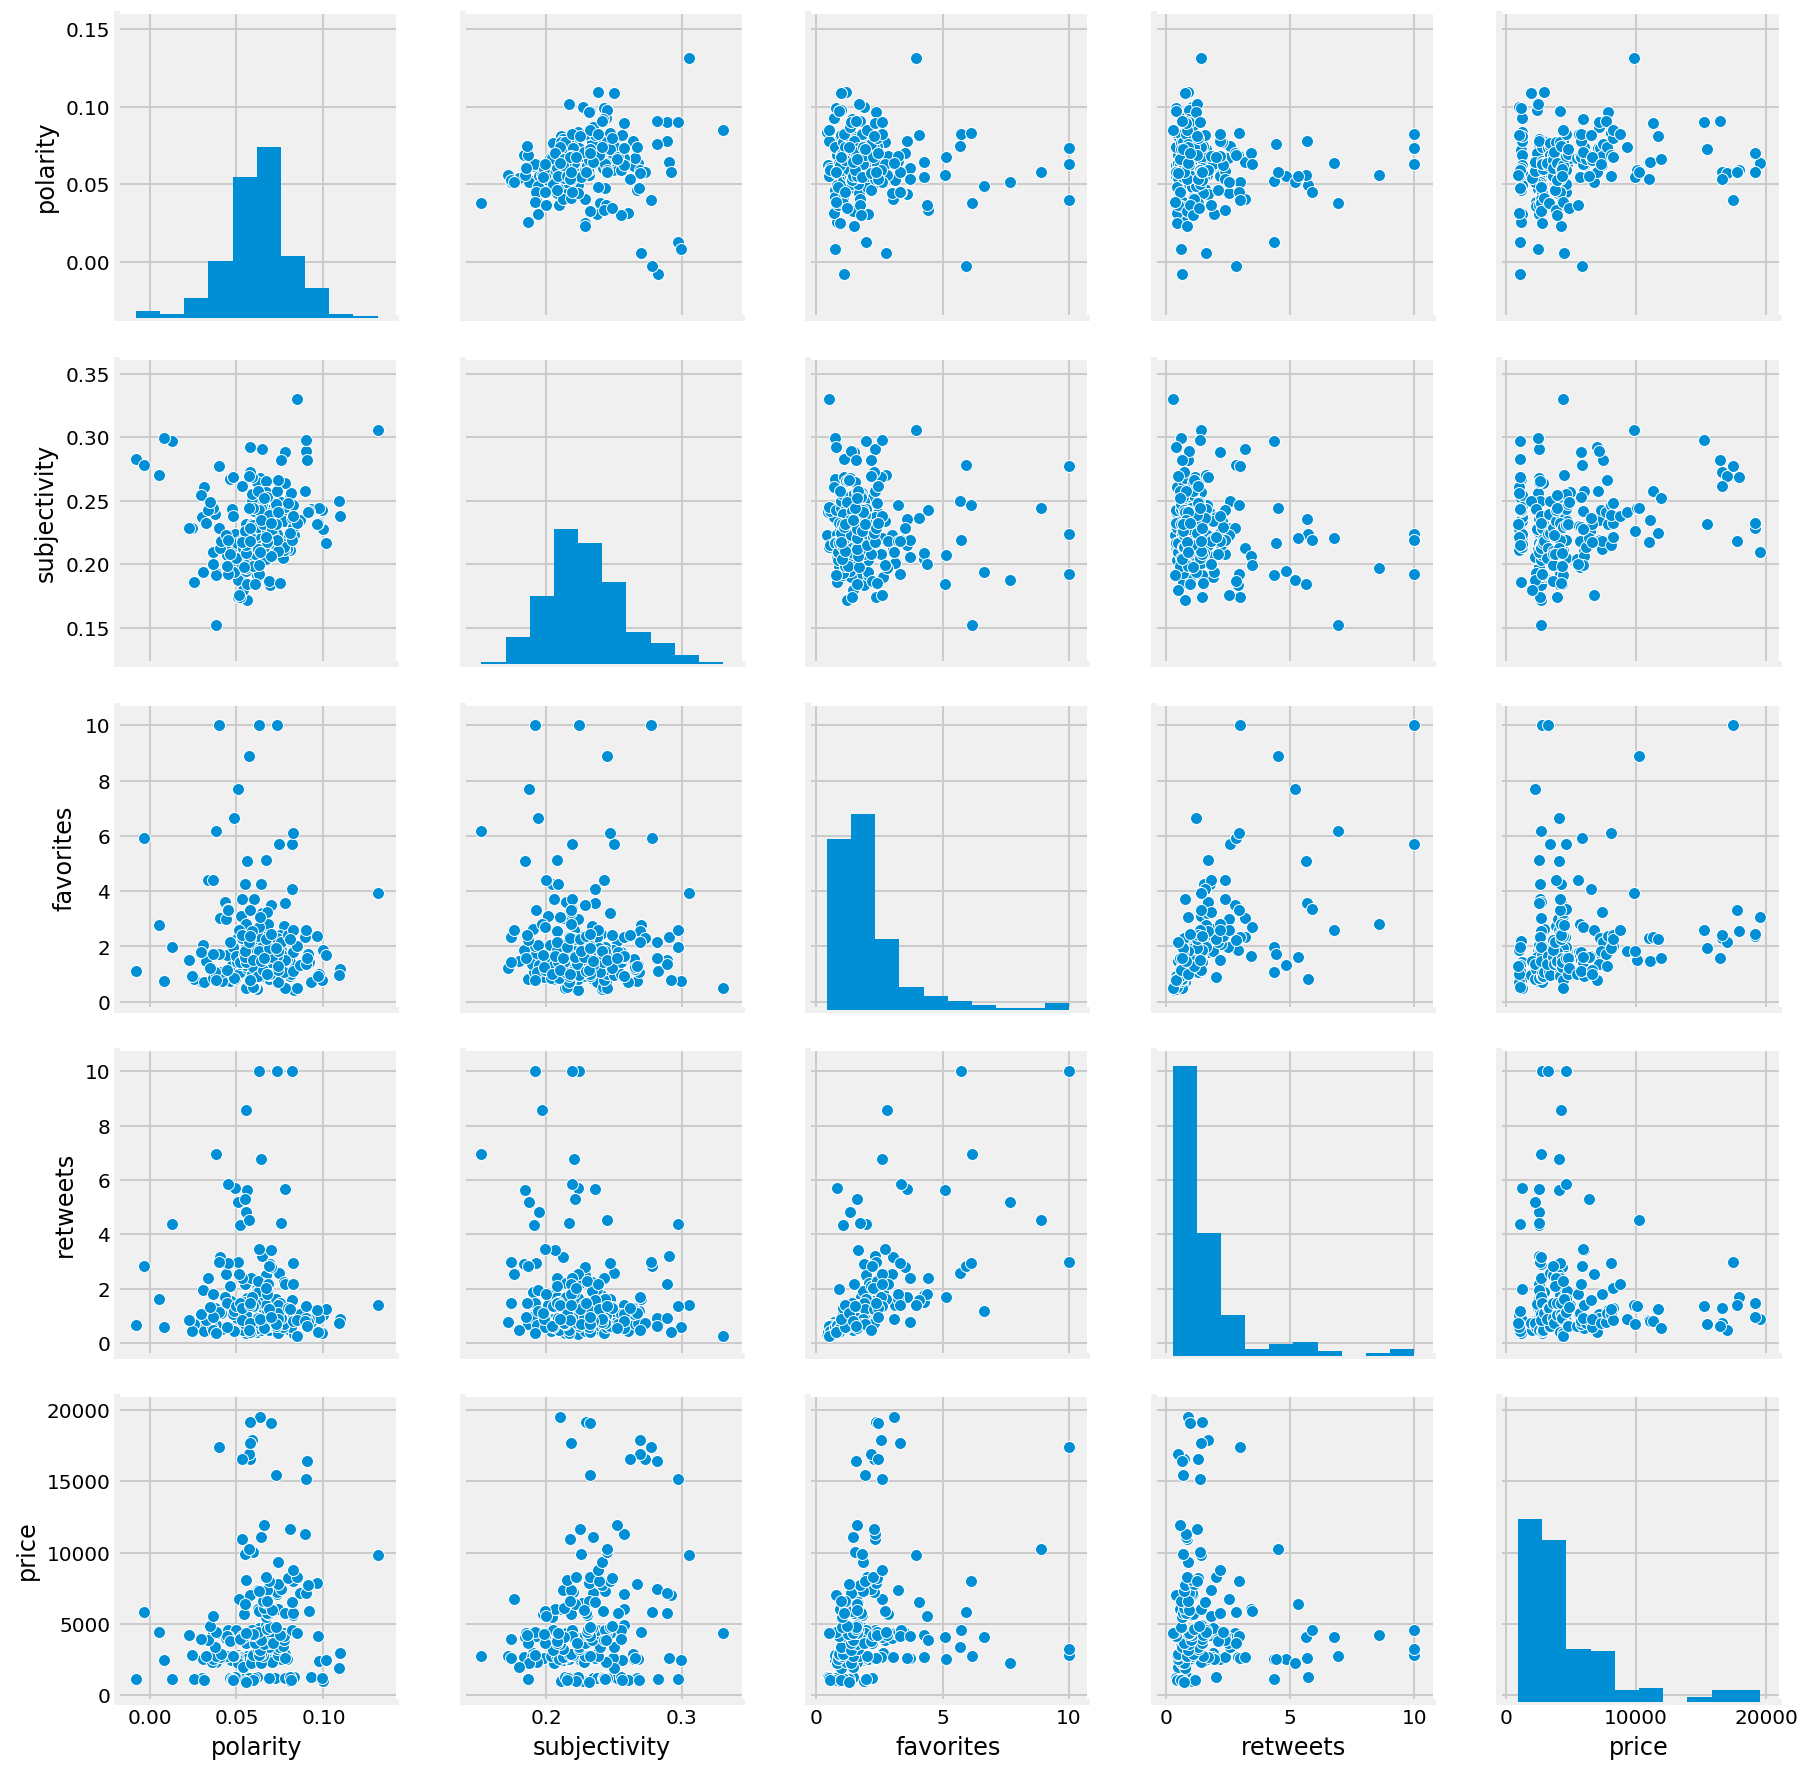

In [64]:
sns.pairplot(c_df[c_df.index.str.contains('2017')])

## Visual observations of patterns

Before going into more advanced modelling, it may be useful to visually observe the data, as it give some insights into how to model the data later. For simplicity, only polarity and price are observed.

### Plotting Standardised Data

Simply plotting standardised Ddata did not seem to result in an easily discernible pattern.

In [2]:
def z_score_plotter(df):
    df = (df-np.mean(df)) / np.std(df)
    df.plot(figsize=(20,12))

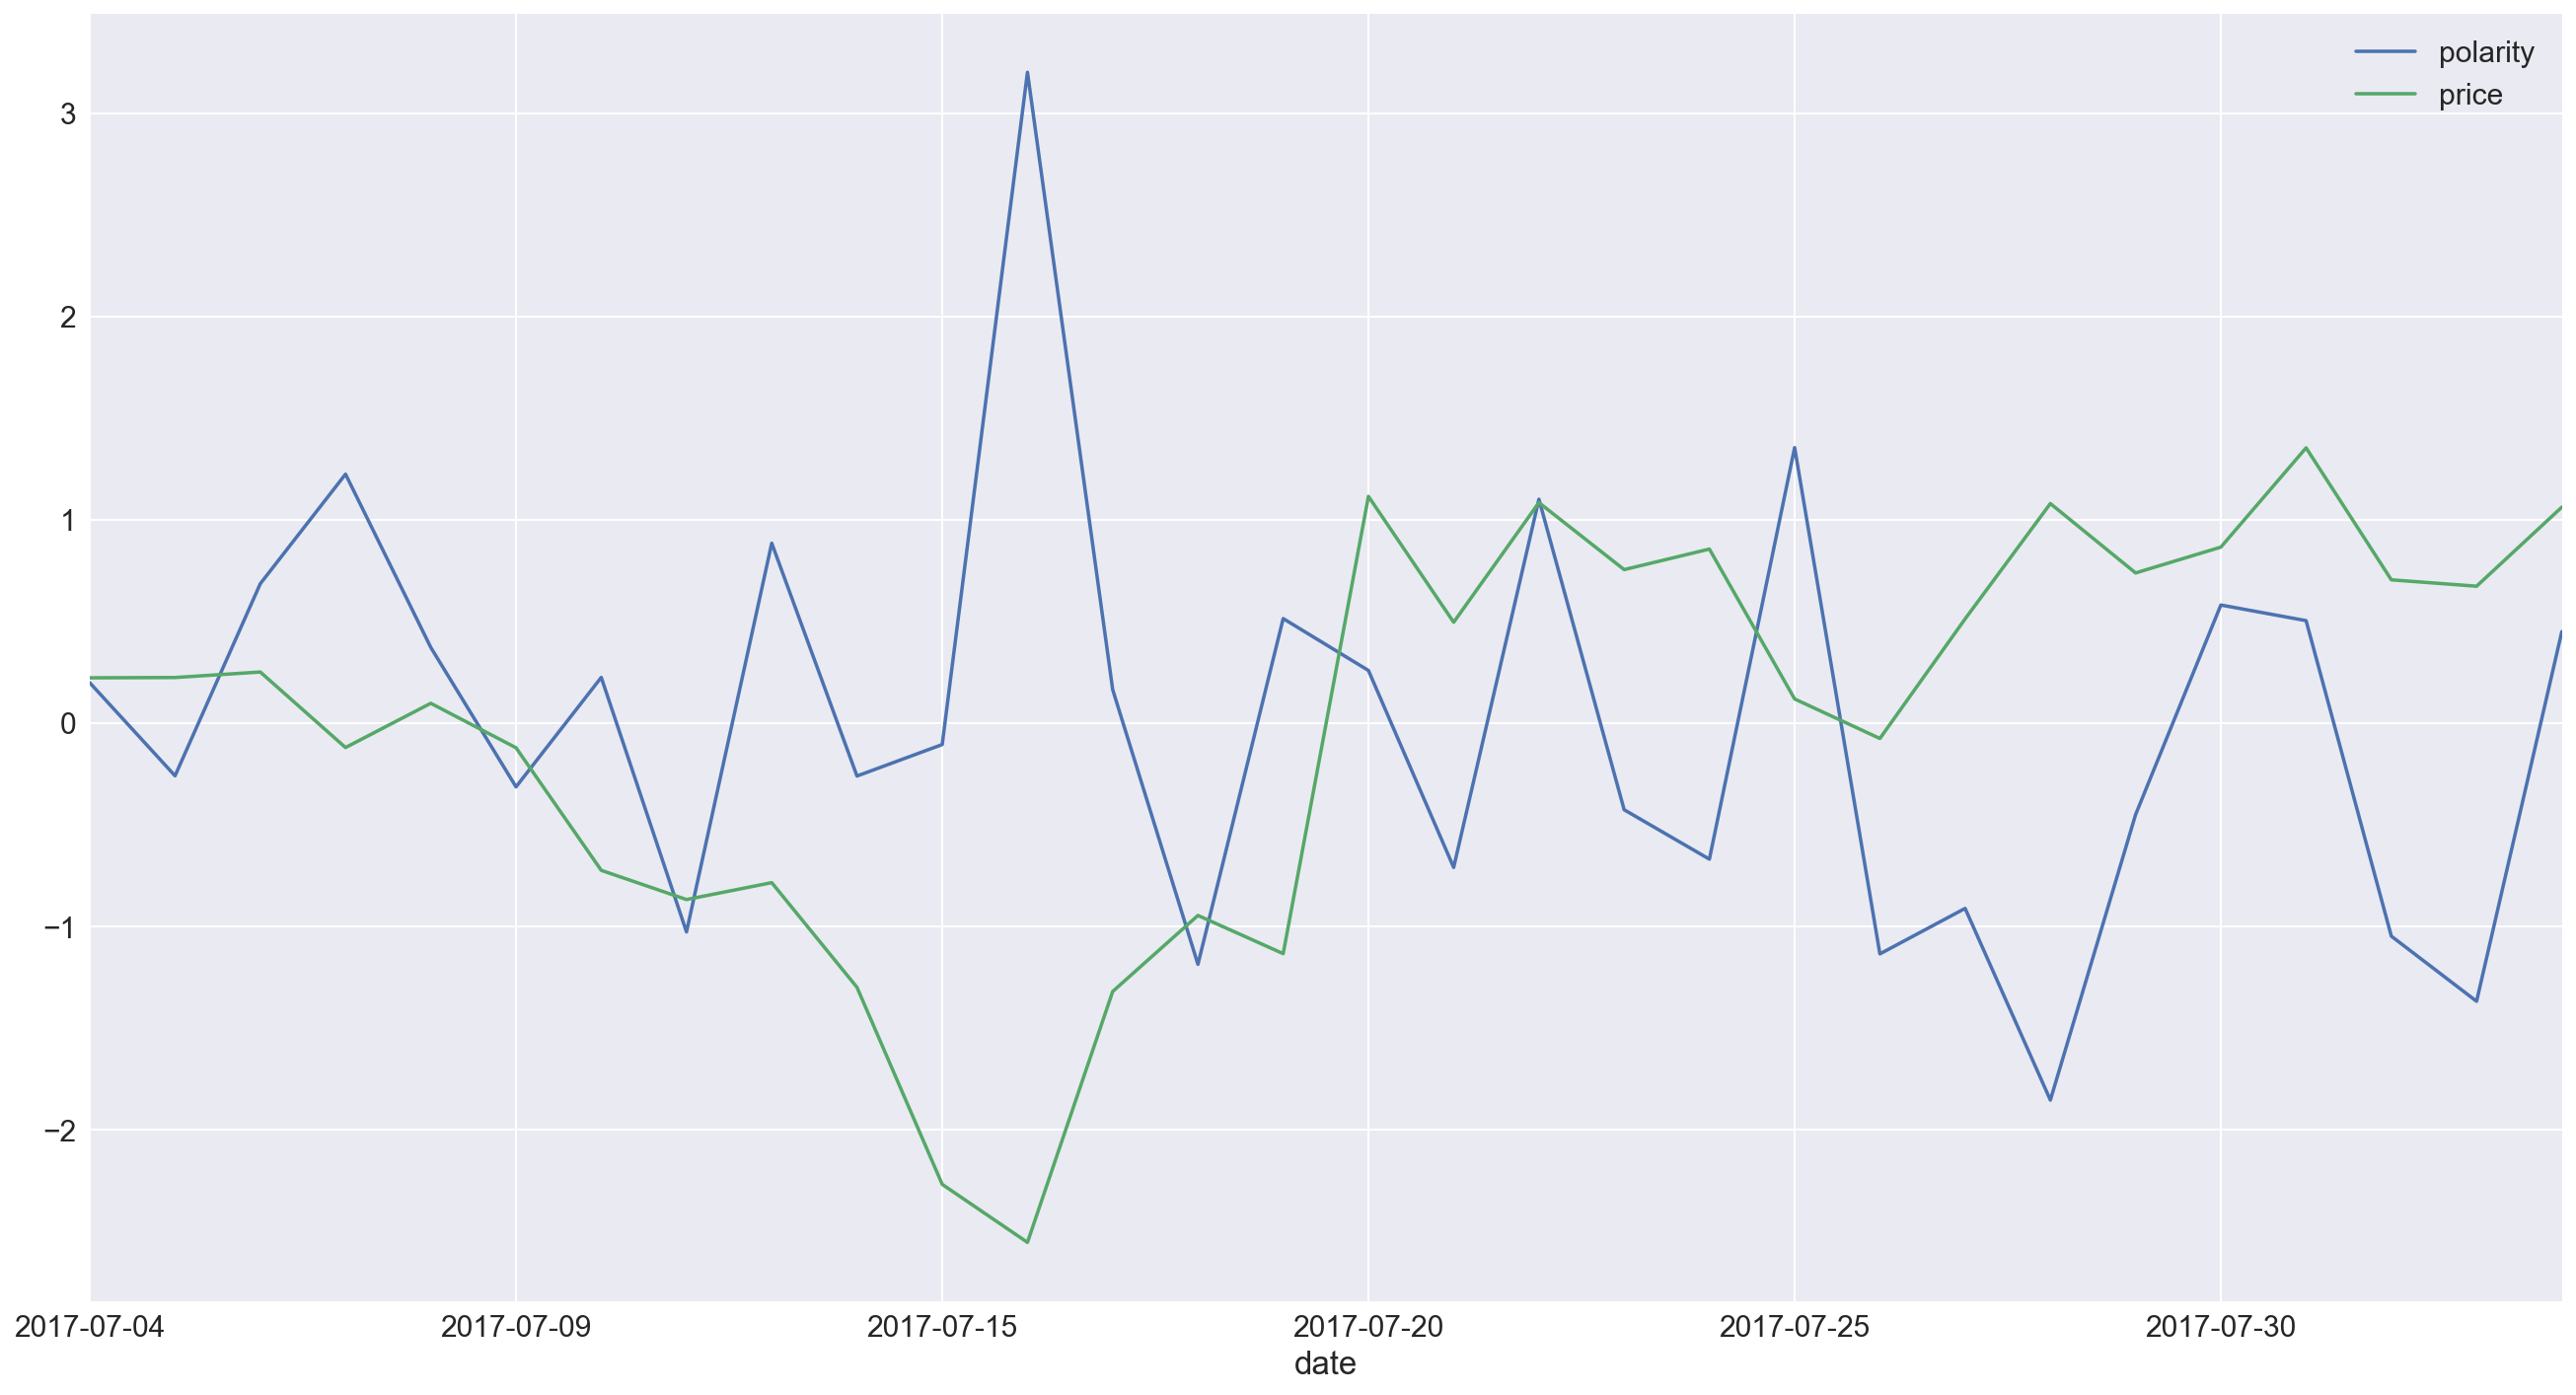

In [35]:
z_score_plotter(df_2017.iloc[60:90,[0,4]])

### Plotting rise/falls

Observing a snapshot of the rise and falls along with polarity, some pattern can be discerned. At some points in time, an increase in polarity relates to an increase in price. At times, it seems like the pattern occurs after a time lag. Time-Series modelling will allow for better insight.

In [13]:
df_2017_rise = df_2017.copy() 
df_2017_rise['diff'] = df_2017_rise['price'].diff()
df_2017_rise['change'] = df_2017_rise['diff'].map(lambda x: 1 if x >=0 else 0)

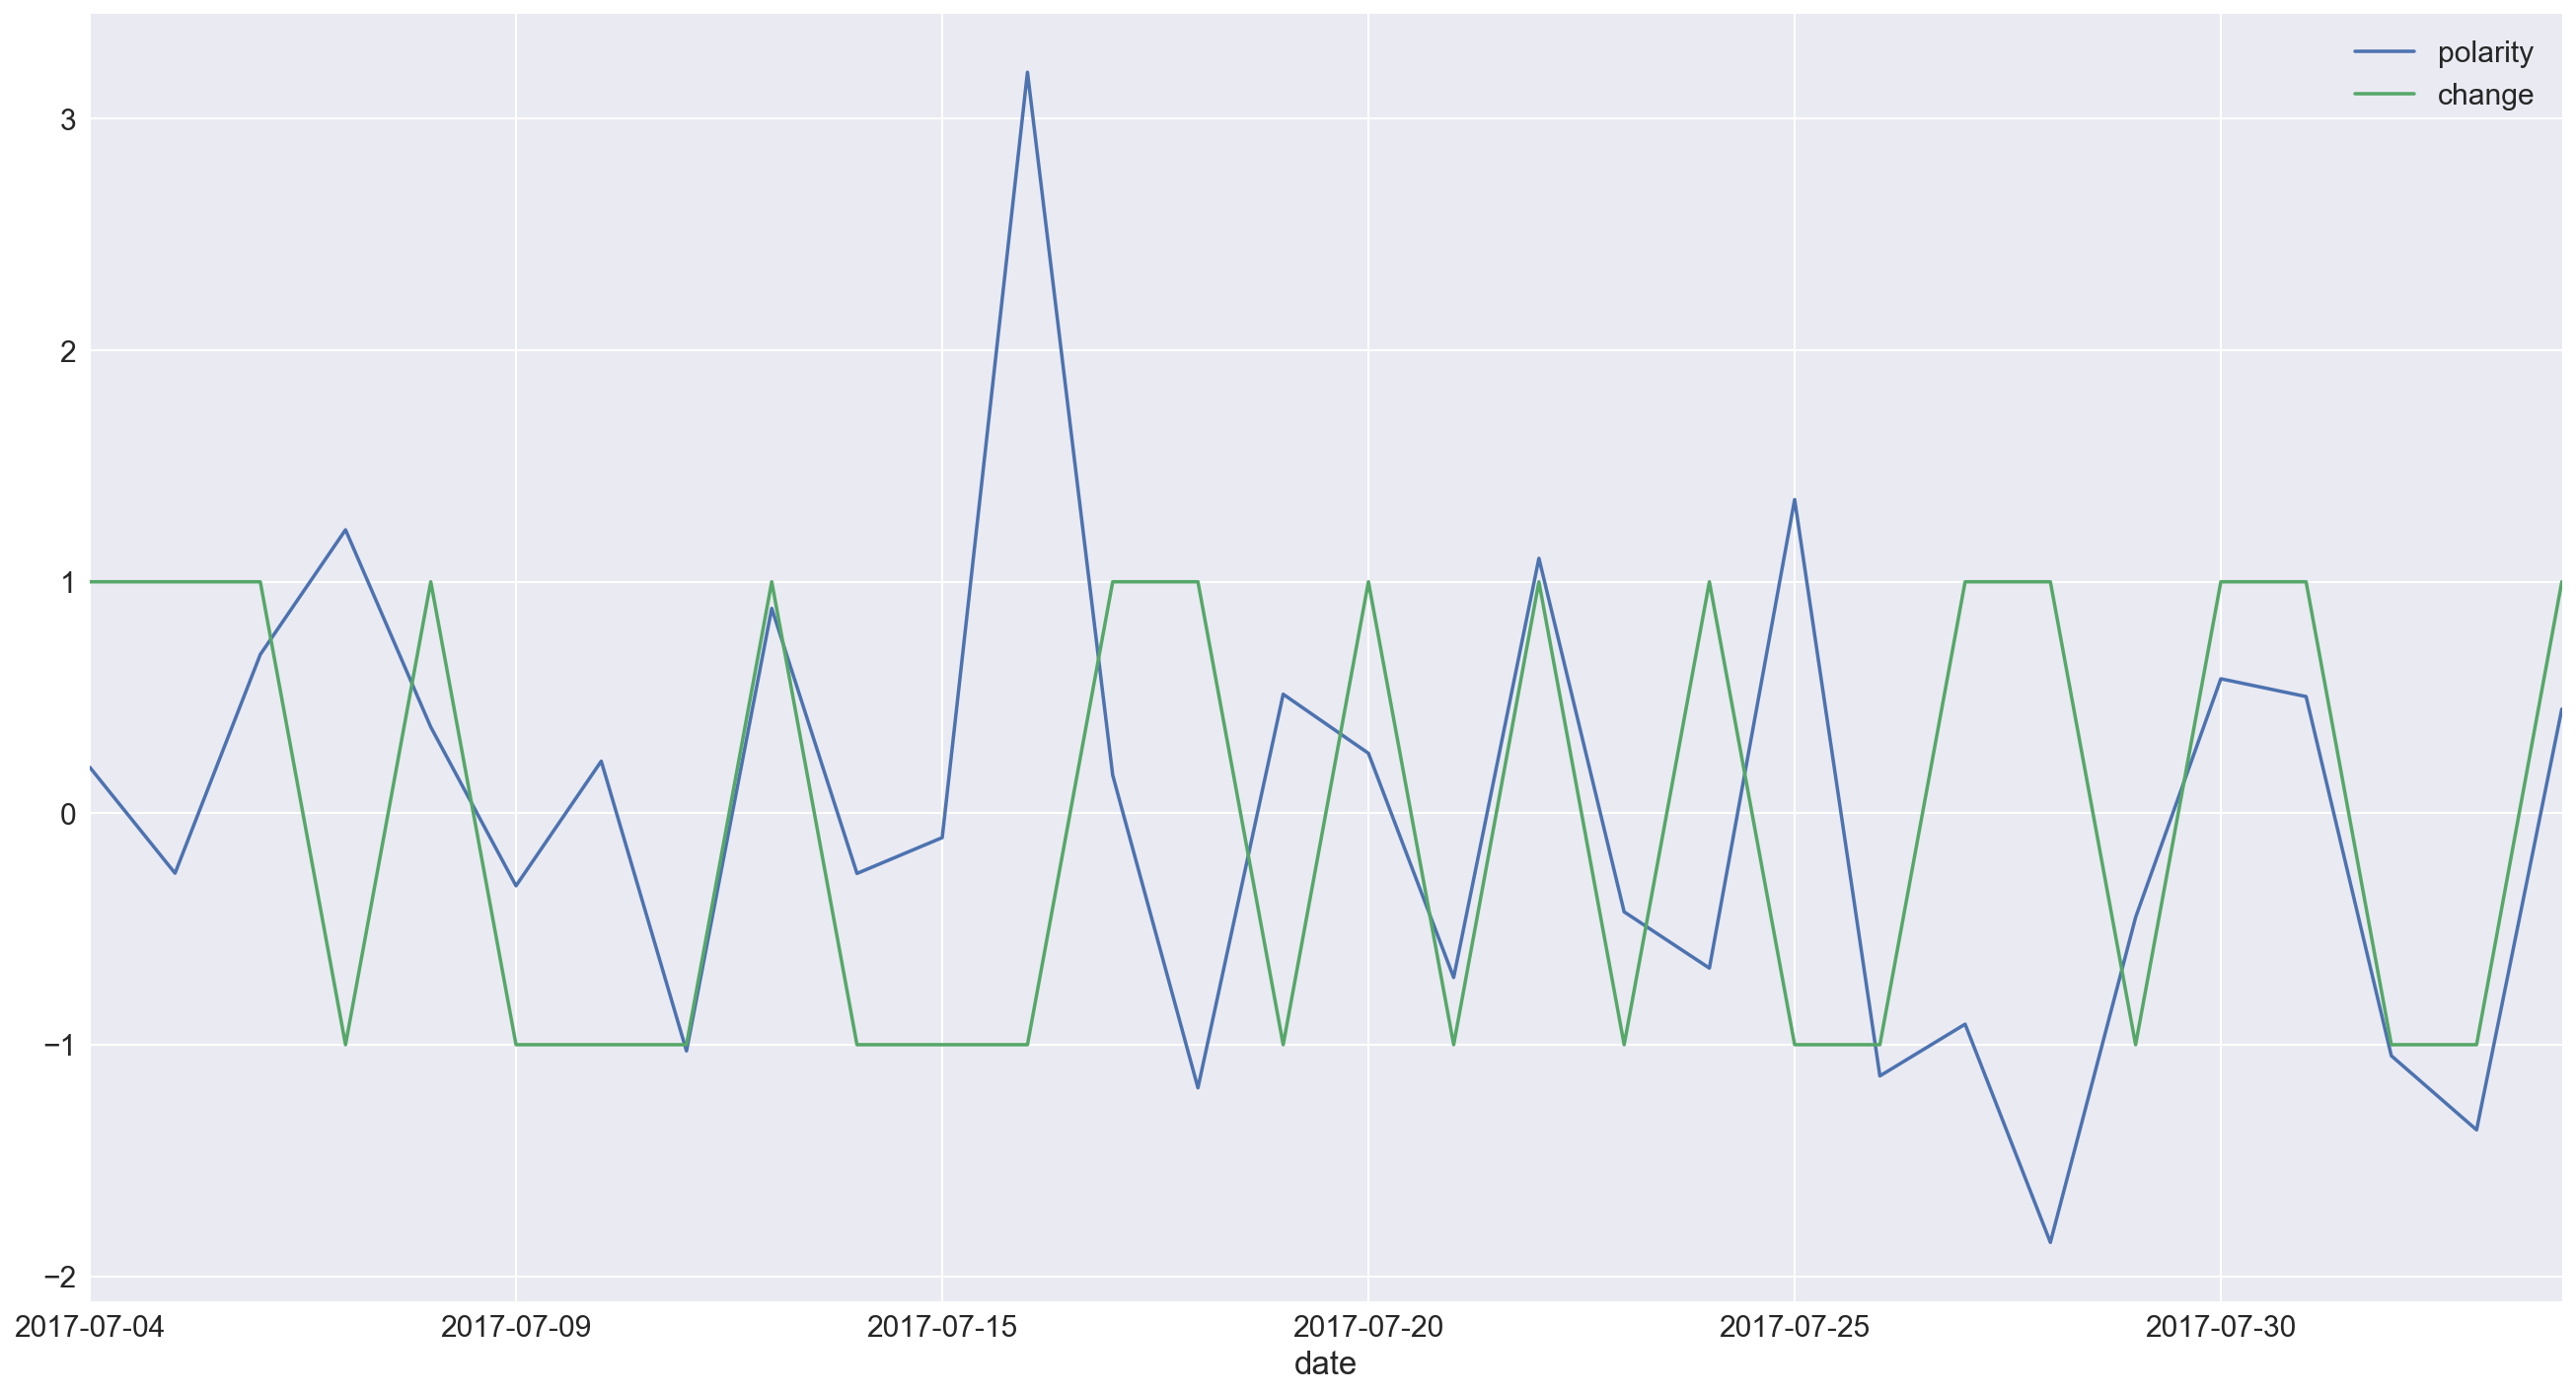

In [34]:
z_score_plotter(df_2017_rise.iloc[60:90,[0,6]])

# Modelling - Multivariate Time-Series Analysis

## Make the Time Series Stationary

Only the last six months of data will be used, as that data is fully complete.

In [18]:
df_2017 = c_df[c_df.index.str.contains('2017')]

In [19]:
df_2017 = df_2017.iloc[27:,:]

In [14]:
df_2017.head()

polarity  subjectivity  favorites  retweets    price
date                                                            
2017-06-01  0.097631      0.244524   0.987654  0.927825  2407.88
2017-06-02  0.101532      0.216899   1.680301  1.246502  2488.55
2017-06-03  0.055900      0.223269   2.262570  1.646182  2515.35
2017-06-04  0.052062      0.191258   1.059172  4.359763  2511.81
2017-06-05  0.069044      0.183878   1.887861  2.910983  2686.81

As can be observed on the graph below, only price needs to be made stationary. This makes sense, as polarity and subjectivity scores will fluctuate between their given range. Furthermore, favorites and retweets also have a stationary trend with fluctuations. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e0b8dd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a1d8ac750>], dtype=object)

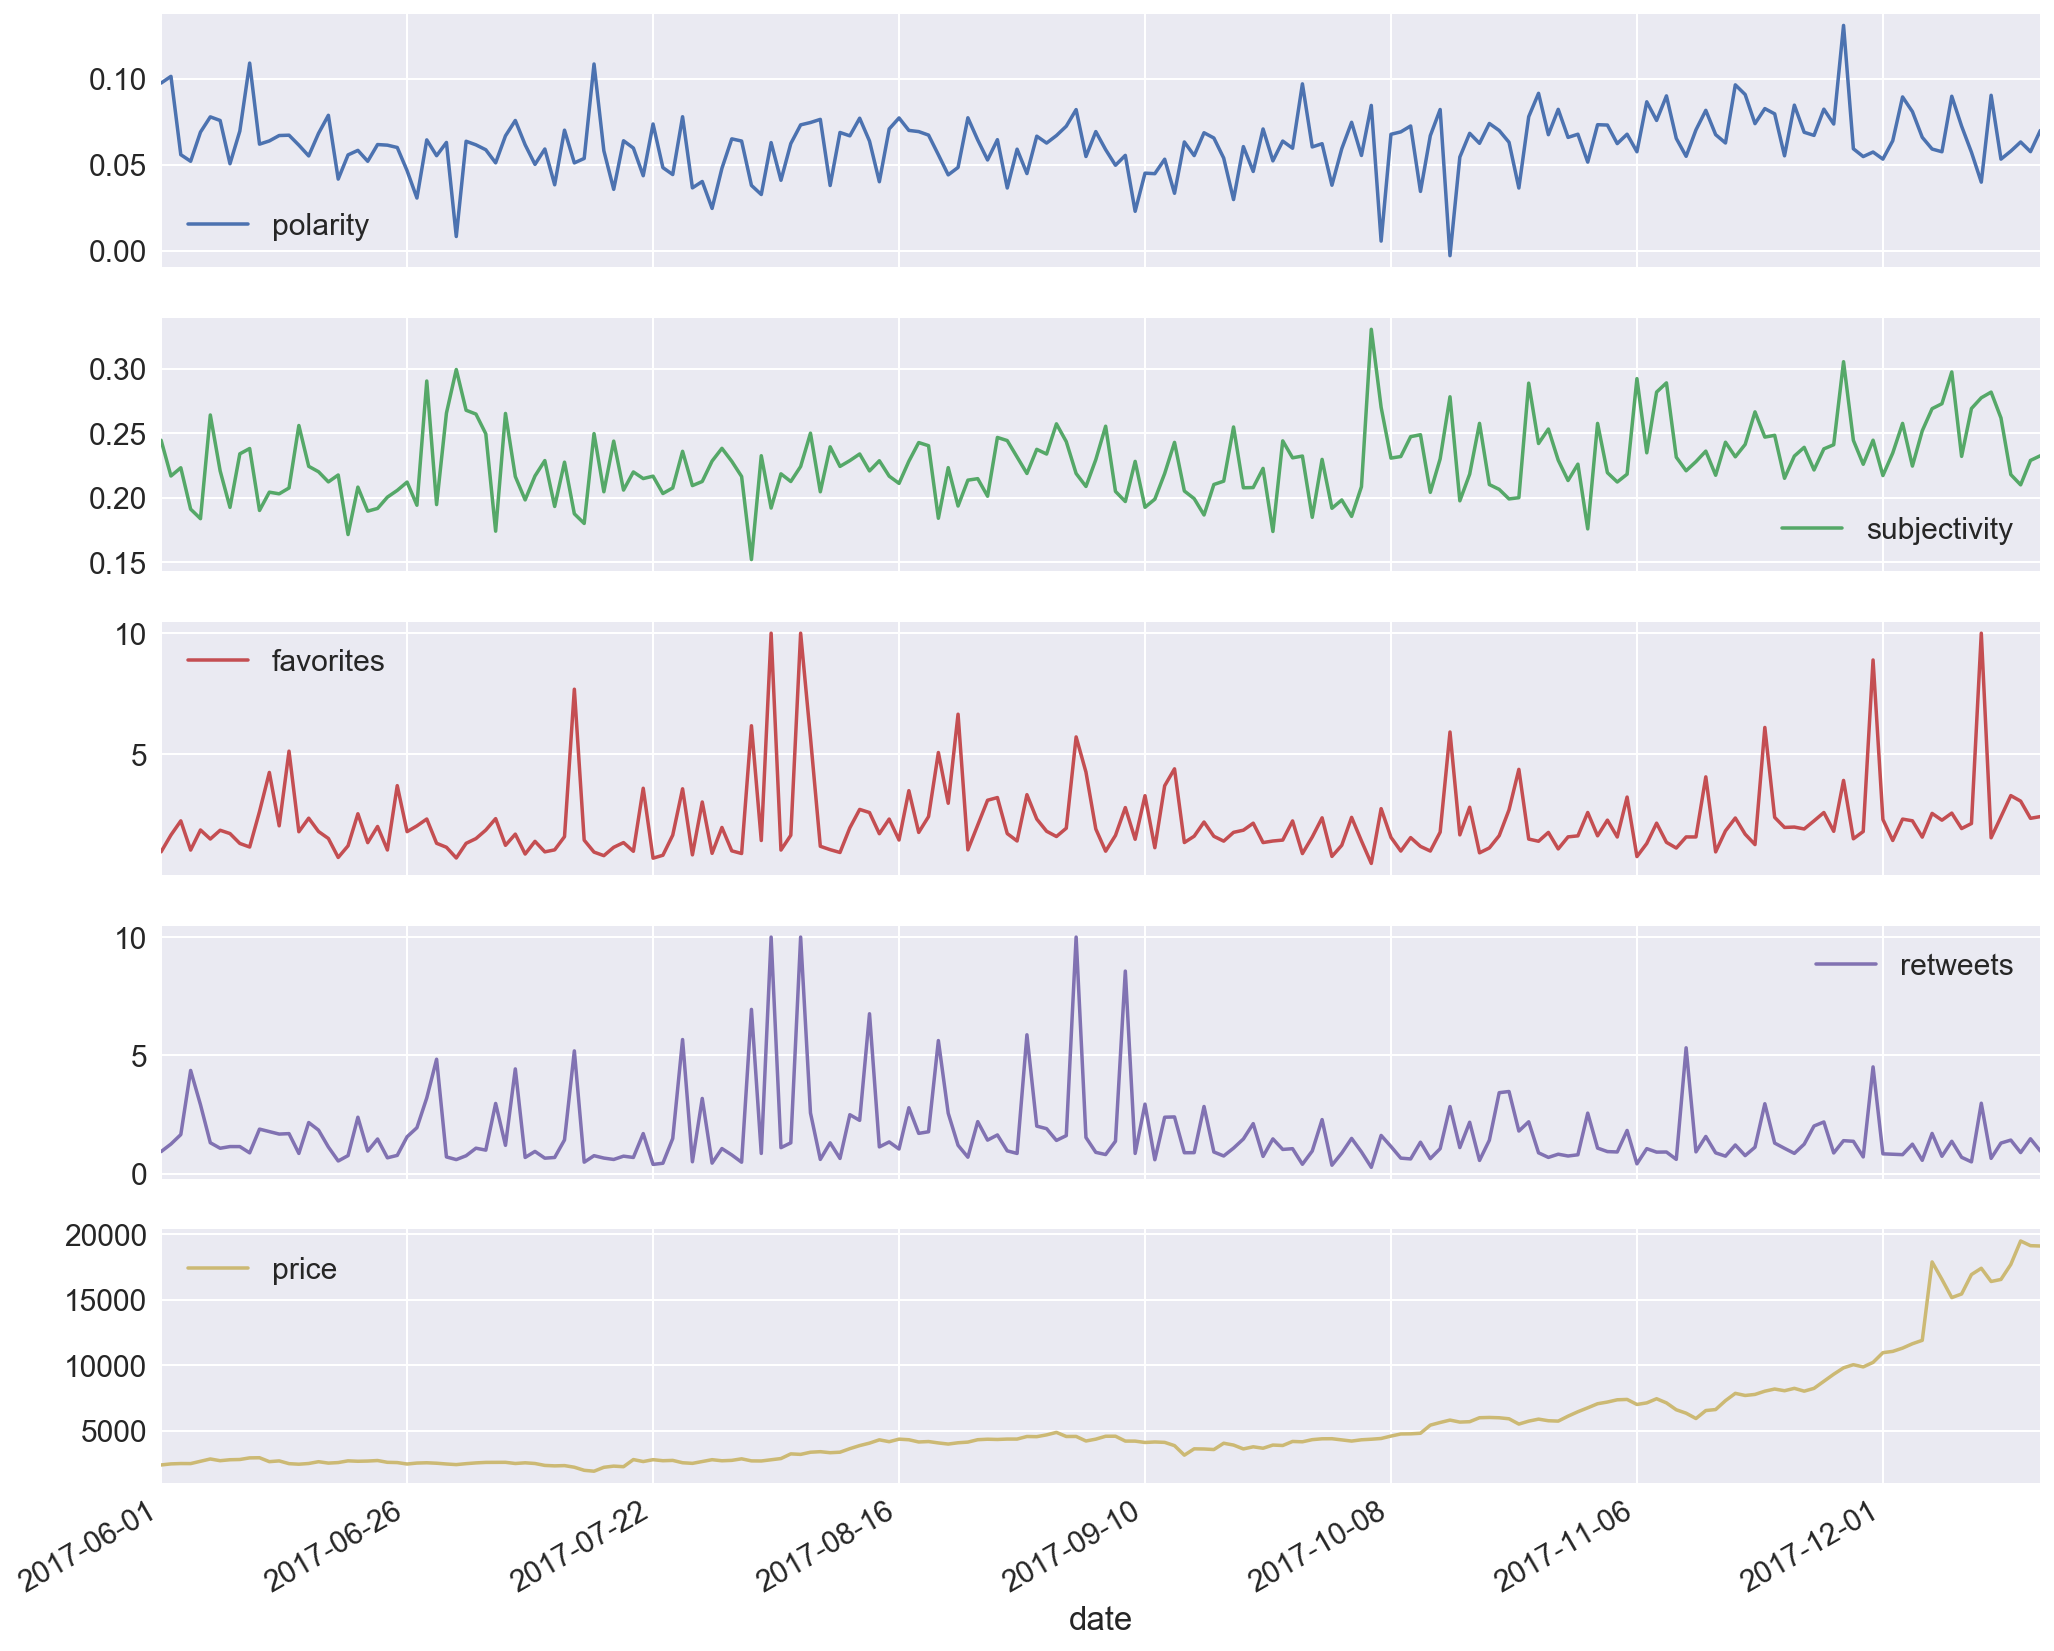

In [83]:
df_2017.plot(subplots=True, figsize=(15,15))

The first attempt to stabilise price, with a simple differing of 1, seems to have been succesful. The upwards trend of price is no longer visible, while the other fluctuations are.

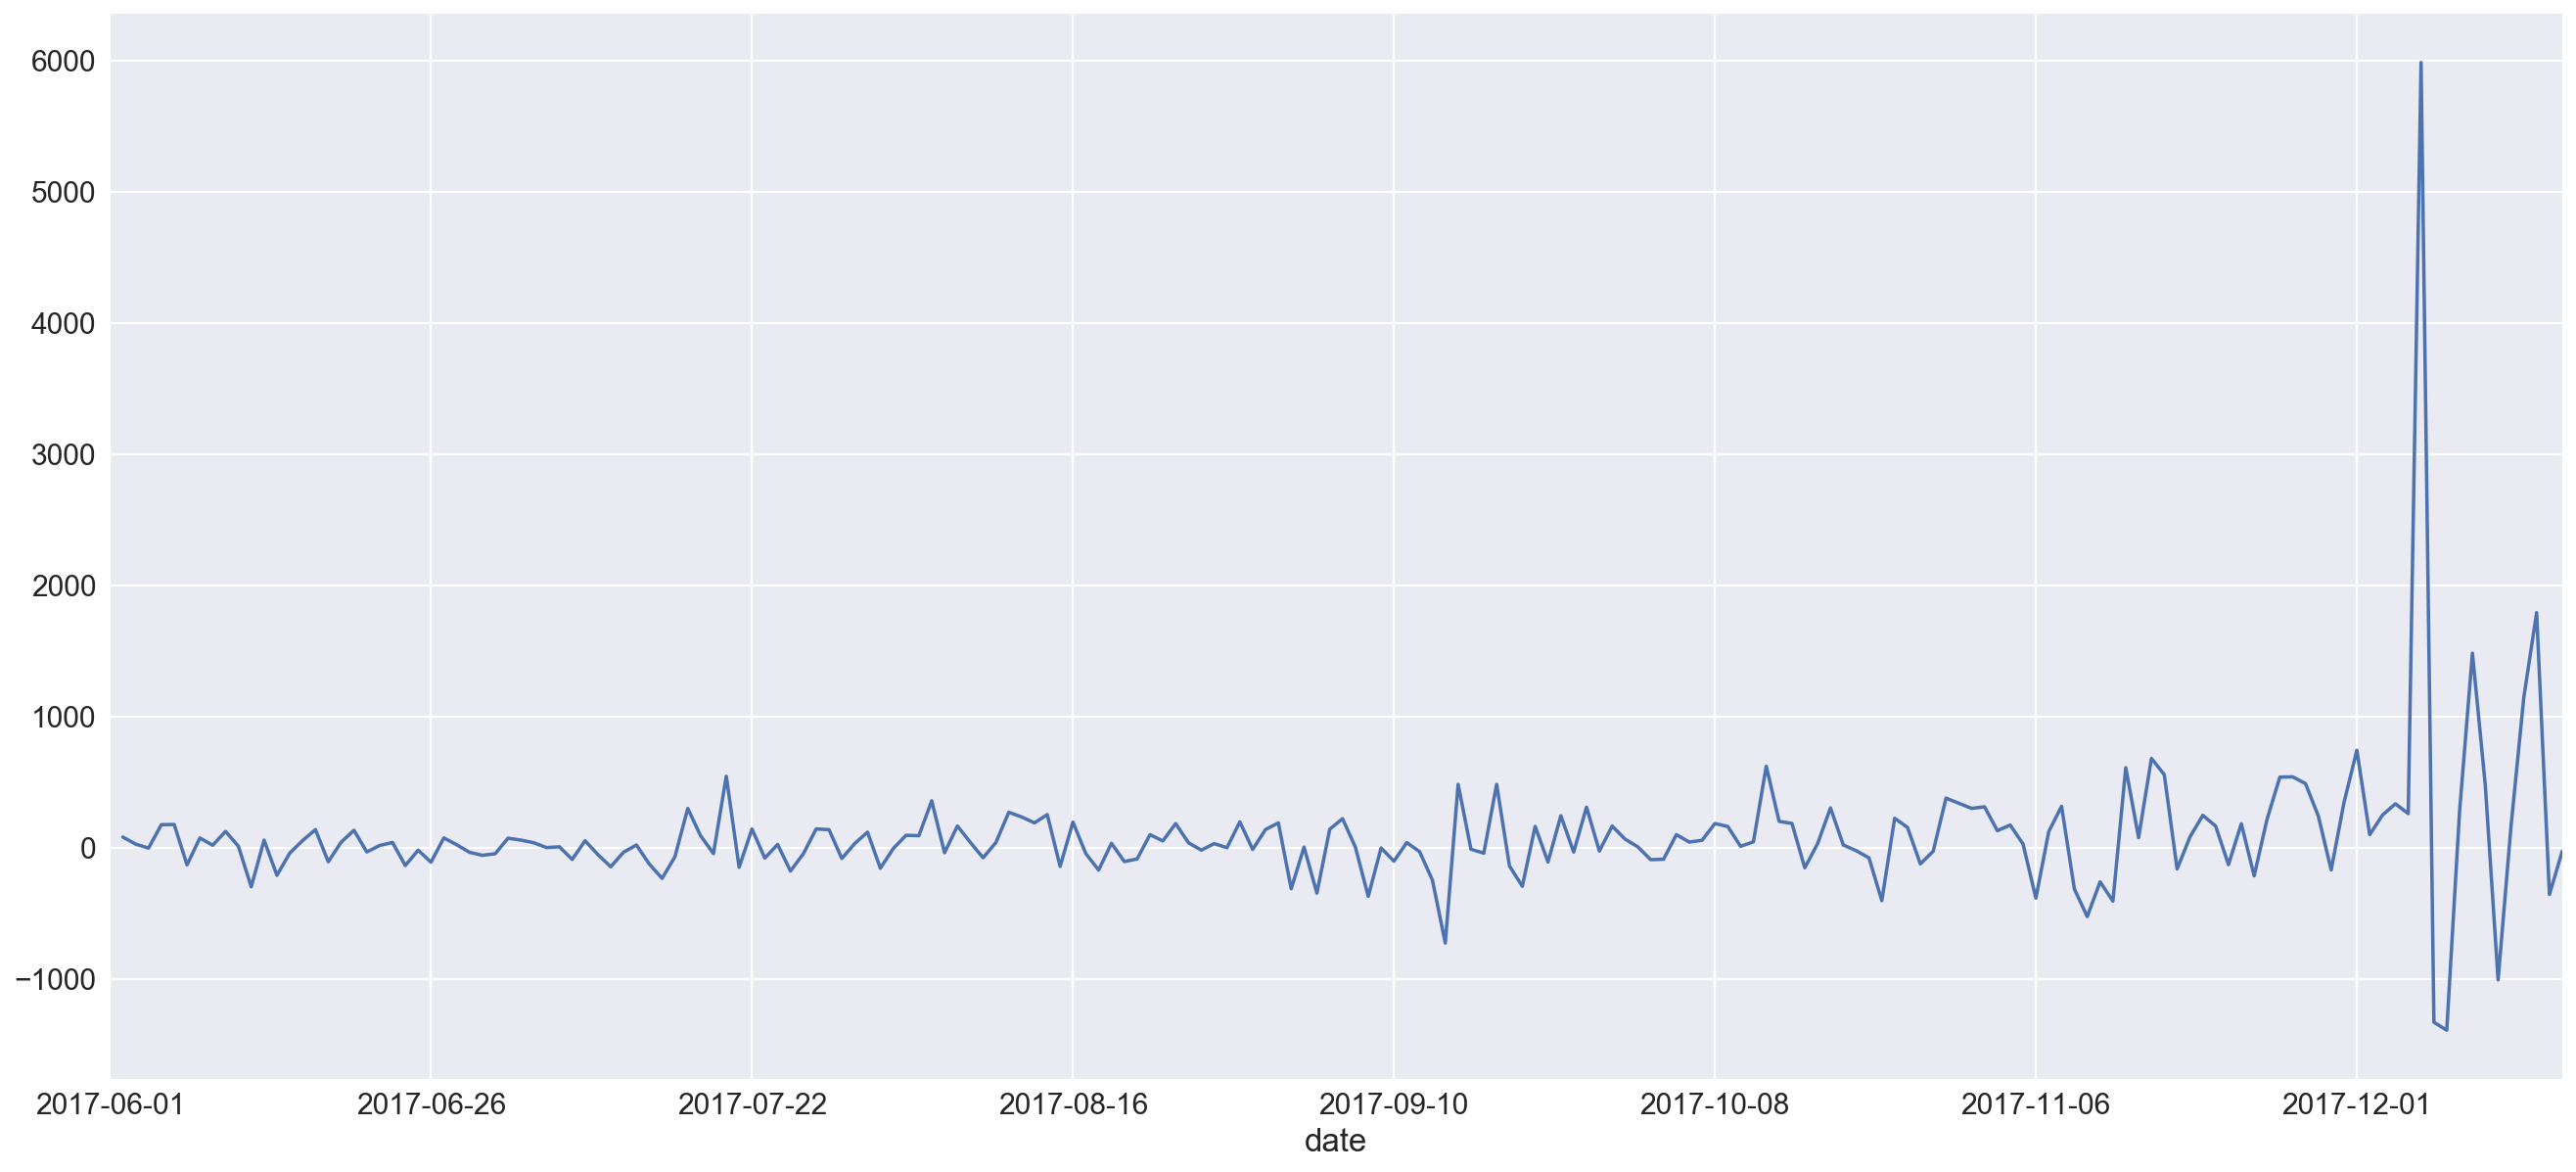

In [87]:
df_2017['price'].diff().plot(figsize=(20,10))

The new model with the differenced price will be saved as a separate vriable

In [20]:
df_2017_1 = df_2017.copy()
df_2017_1['price'] = df_2017_1['price'].diff()
df_2017_1 = df_2017_1[1:]

## Observing Autocorrelation

Let's first observe the autocorrelation for each variable. This will allow seeing how price at different time-lags affects current price. The biggest inference to make out of this is that a change in price in one day is not heavily correlated to a change in. price in another. It seems that with polarity, positive and negative sentiment change in sets. It also seems that a wave of positive sentiment is followed by a wave of negative setniment.

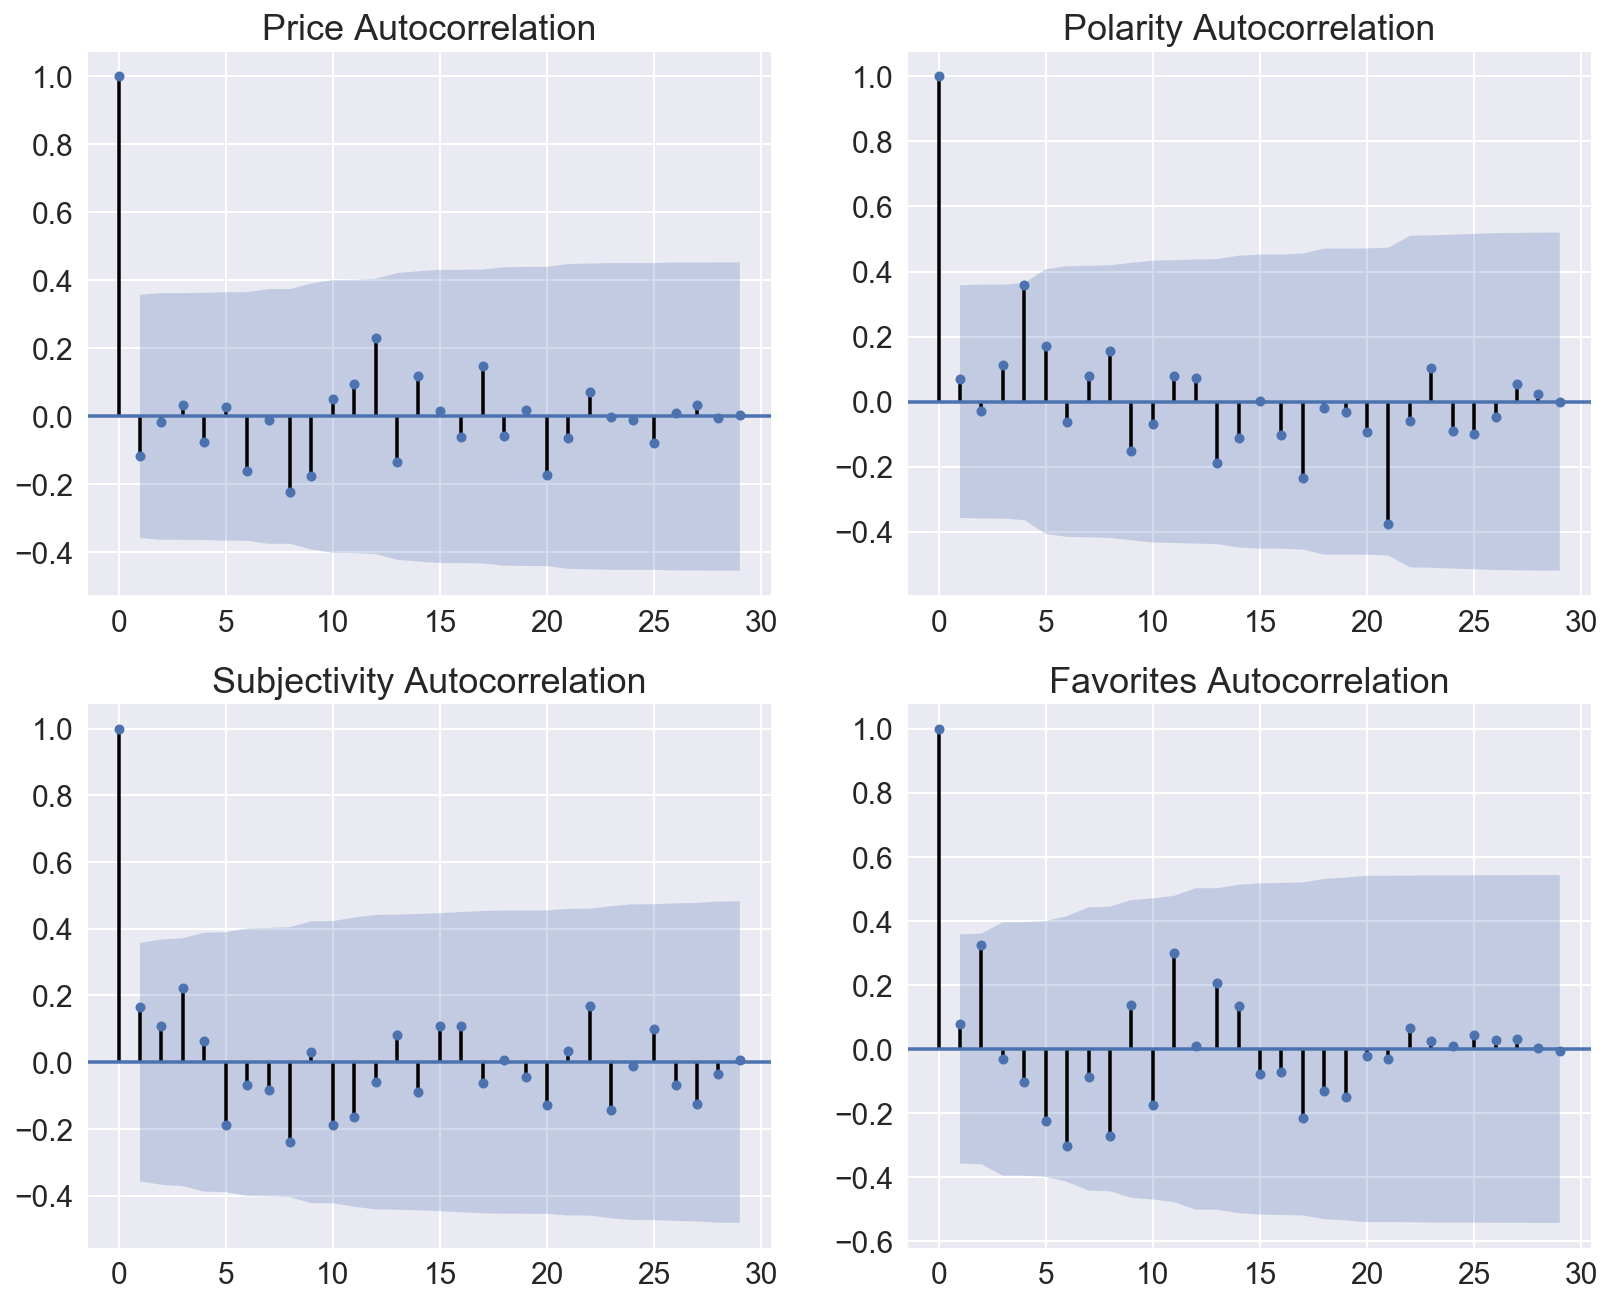

In [50]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(12,11))
plot_acf(df_2017_1.price[1:31],ax=ax[0,0],title='Price Autocorrelation')
plot_acf(df_2017_1.polarity[1:31],ax=ax[0,1],title='Polarity Autocorrelation')
plot_acf(df_2017_1.subjectivity[1:31],ax=ax[1,0],title='Subjectivity Autocorrelation')
plot_acf(df_2017_1.favorites[1:31],ax=ax[1,1],title='Favorites Autocorrelation')
plt.show()

## Observing Cross-correlations Through Time Lags

Cross-correlations is a measure of correlation at different time lag positions. The following graph shows the cross-correlation among different variables. Time series model data is not independant, and thus looking at a correlation matrix only shows a small part of the picture. This allows us to observe a better relationship between variables.

Before doing this, the time series must be made stationary, as was done in the previous step.

The cross-correlations show that  polarity and price  as well as subjectivity and price, are positively correlated, even at multiple time lags. 

#Ok don't understand this - especially why is price-polarity completely different to polarity-price?

https://git.generalassemb.ly/DSI-LDN-4/lessons-repo/blob/master/week09/day4_timeseries_seasonal_arima_and_varma/varma_lesson/VARMA_models.ipynb

In [9]:
def cross_corr_varma_plotter(df_1):
    df_1 = df_1.reset_index().drop('date',axi s=1)
    fig, ax = plt.subplots(nrows=2,ncols=len(df_1.columns),figsize=(30,15),sharex=True,sharey=True)
    for i, cols in enumerate(combinations(df_1.columns,2)):
        plot_acf(ccf(df_1[cols[0]],df_1[cols[1]]),lags=20,ax=ax[0,i],title='Cross-correlations {}'.format(cols))
        plot_acf(ccf(df_1[cols[1]],df_1[cols[0]]),lags=20,ax=ax[1,i],title='Cross-correlations {}'.format(cols[-1::-1]))
    plt.show()

SyntaxError: invalid syntax (<ipython-input-9-ede9a52295c1>, line 2)

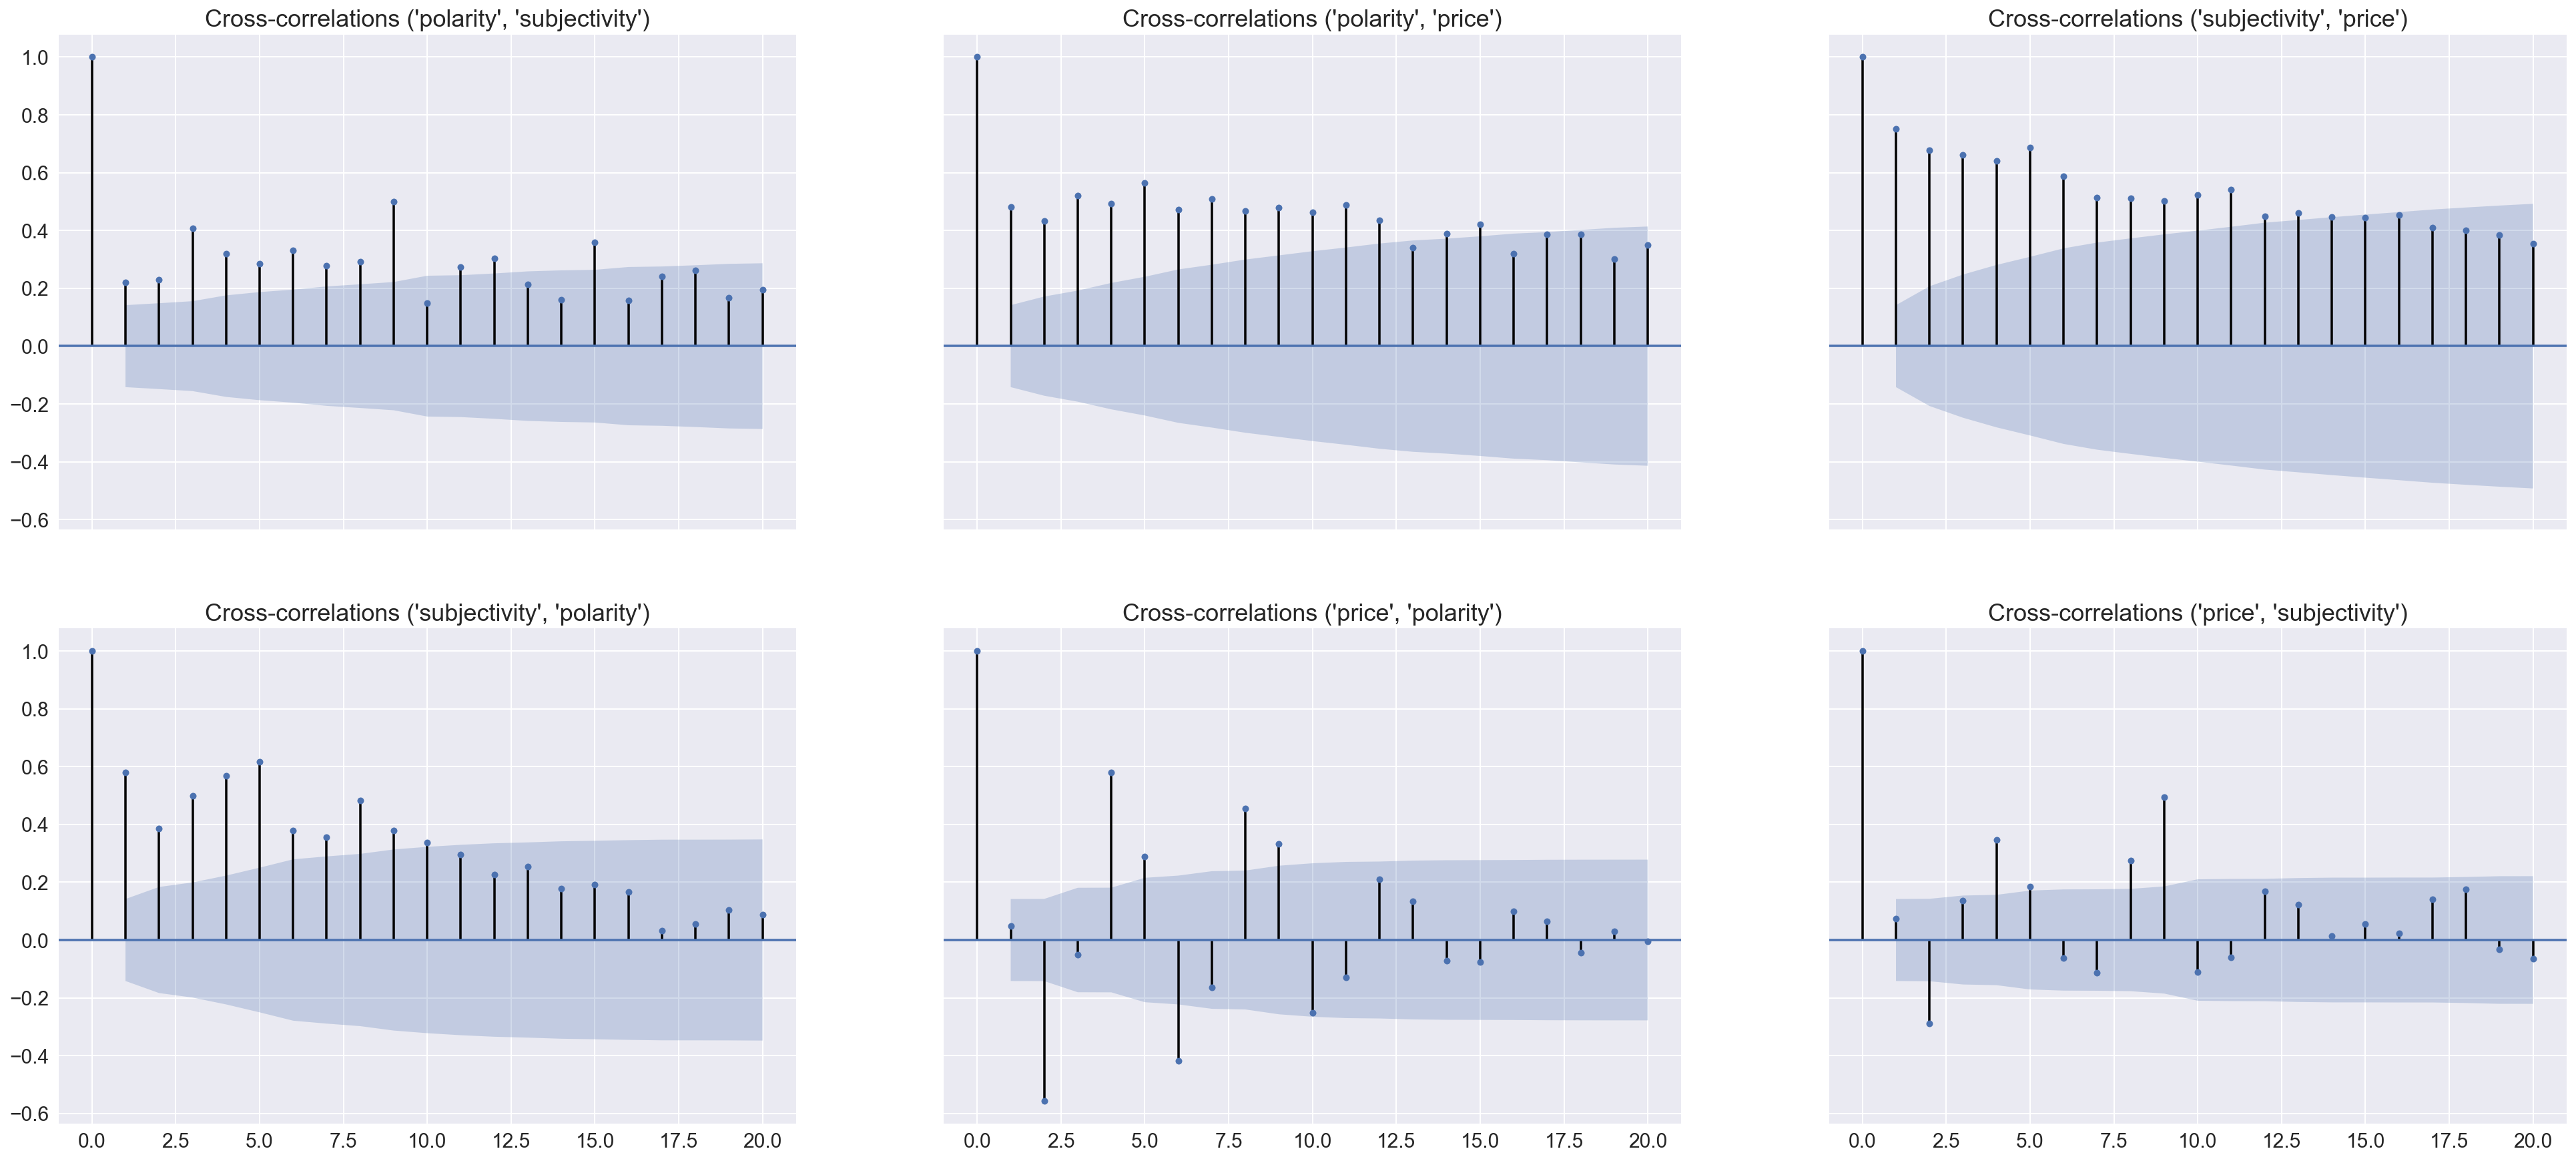

In [26]:
cross_corr_varma_plotter(df_2017_1.iloc[:,[0,1,4]])

## Running the Model


Now that EDA has been performed, and the data has been stationarised, the time series data will be fitted into a a model. A VARMAX model (vector autoregressive moving-average model with exogenous variables) will be used, as it is approrpiate for multiple time-series data.

In [11]:
c_df = pd.read_csv('cleaned_data_2017-01-13').set_index('date')

df_2017 = c_df[c_df.index.str.contains('2017')]
df_2017 = df_2017.iloc[27:,:]

df_2017_1 = df_2017.copy()
df_2017_1['price'] = df_2017_1['price'].diff()
df_2017_1 = df_2017_1[1:]

In [10]:
df_2017_1.set_index(pd.DatetimeIndex(df_2017_1.index),inplace=True)

In [16]:
model = sm.tsa.VARMAX(df_2017_1.loc[:,:].values, order=(5,1),trend='c',enforce_stationarity=True)
results = model.fit(maxiter=5000,method='powell')
results.summary()

Optimization terminated successfully.
         Current function value: 5.924252
         Iterations: 17
         Function evaluations: 32952


/Users/matthias/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/matthias/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/matthias/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/matthias/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     ['y1', 'y2', 'y3', 'y4', 'y5']   No. Observations:                  191
Model:                                 VARMA(5,1)   Log Likelihood               -1131.532
                                      + intercept   AIC                           2603.064
Date:                            Mon, 22 Jan 2018   BIC                           3155.951
Time:                                    09:57:16   HQIC                          2827.009
Sample:                                         0                                         
                                            - 191                                         
Covariance Type:                              opg                                         
================================================================================================================================
Ljung-Box (Q):          79.22, 25.48, 22.24, 24.67, 25.47   Jarque-Bera (JB):   22221.50, 59280.62, 53231.18, 59258.77, 59897.68
Prob(Q):                     0.00, 0.96, 0.99, 0.97, 0.96   Prob(JB):                               0.00, 0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H):   0.00, 15.70, 9.05, 14.89, 16.25   Skew:                                 1.56, -7.65, -7.32, 7.64, 7.68
Prob(H) (two-sided):         0.00, 0.00, 0.00, 0.00, 0.00   Kurtosis:                          55.75, 87.94, 83.46, 87.93, 88.38
                           Results for equation y1                            
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0252      0.324      0.078      0.938      -0.611       0.661
L1.y1          0.1418      6.169      0.023      0.982     -11.950      12.234
L1.y2         -0.0146      1.698     -0.009      0.993      -3.343       3.314
L1.y3          0.0026      0.016      0.165      0.869      -0.029       0.034
L1.y4         -0.0027      0.012     -0.233      0.816      -0.026       0.020
L1.y5      -1.728e-06   8.71e-05     -0.020      0.984      -0.000       0.000
L2.y1         -0.0108      0.457     -0.024      0.981      -0.907       0.885
L2.y2          0.0432      0.226      0.191      0.848      -0.399       0.486
L2.y3          0.0001      0.011      0.012      0.991      -0.022       0.022
L2.y4          0.0008      0.020      0.040      0.968      -0.039       0.041
L2.y5       2.221e-06   1.65e-05      0.134      0.893   -3.02e-05    3.46e-05
L3.y1          0.0692      0.359      0.193      0.847      -0.634       0.773
L3.y2         -0.0003      0.502     -0.001      0.999      -0.984       0.983
L3.y3          0.0006      0.006      0.108      0.914      -0.010       0.011
L3.y4         -0.0008      0.003     -0.239      0.811      -0.007       0.006
L3.y5       7.484e-07   2.06e-05      0.036      0.971   -3.95e-05     4.1e-05
L4.y1          0.1245      0.393      0.316      0.752      -0.647       0.896
L4.y2          0.0104      0.340      0.031      0.976      -0.656       0.677
L4.y3          0.0012      0.006      0.192      0.847      -0.011       0.014
L4.y4         -0.0003      0.005     -0.072      0.943      -0.009       0.009
L4.y5       -1.77e-06   1.44e-05     -0.123      0.902   -3.01e-05    2.65e-05
L5.y1          0.0536      1.176      0.046      0.964      -2.252       2.359
L5.y2          0.0004      0.204      0.002      0.999      -0.399       0.400
L5.y3         -0.0012      0.011     -0.110      0.912      -0.023       0.020
L5.y4          0.0014      0.005      0.298      0.766      -0.008       0.011
L5.y5      -1.459e-06   2.01e-05     -0.073      0.942   -4.08e-05    3.79e-05
L1.e(y1)      -0.1038      

### Forecasting price

The results.forecast method allows forecasting future values for all variables (sentiment, favorites, price,...). A price prediction is shown for the next day of the current day (December 19th)

The results.forecast method allows 

In [17]:
one_day_forecast = results.forecast(steps=1)
df_2017.iloc[-1,4] + one_day_forecast[0][4]

#Another way to check
#(df_2017.price[0]+df_2017_1.price.cumsum()).plot()

19223.151965848301

The following graph plots the (differenced) predictions for the following 10 days.

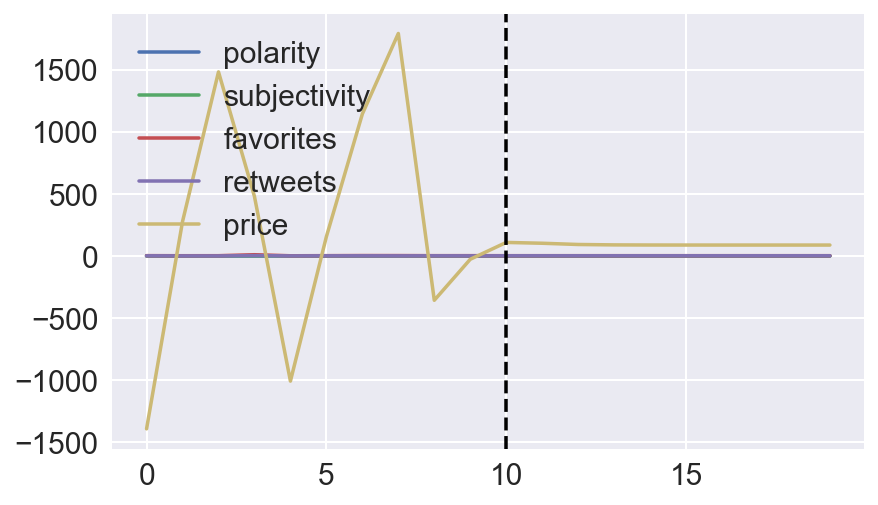

In [22]:
plt.plot(np.concatenate((df_2017_1[-10:],results.forecast(steps=10)),axis=0))
plt.axvline(len(df_2017_1[-10:]),color='k',ls='--')
plt.legend([col for col in df_2017_1.columns])
plt.show()

###  TODO - Interpreting the Diagnostics


#TODO

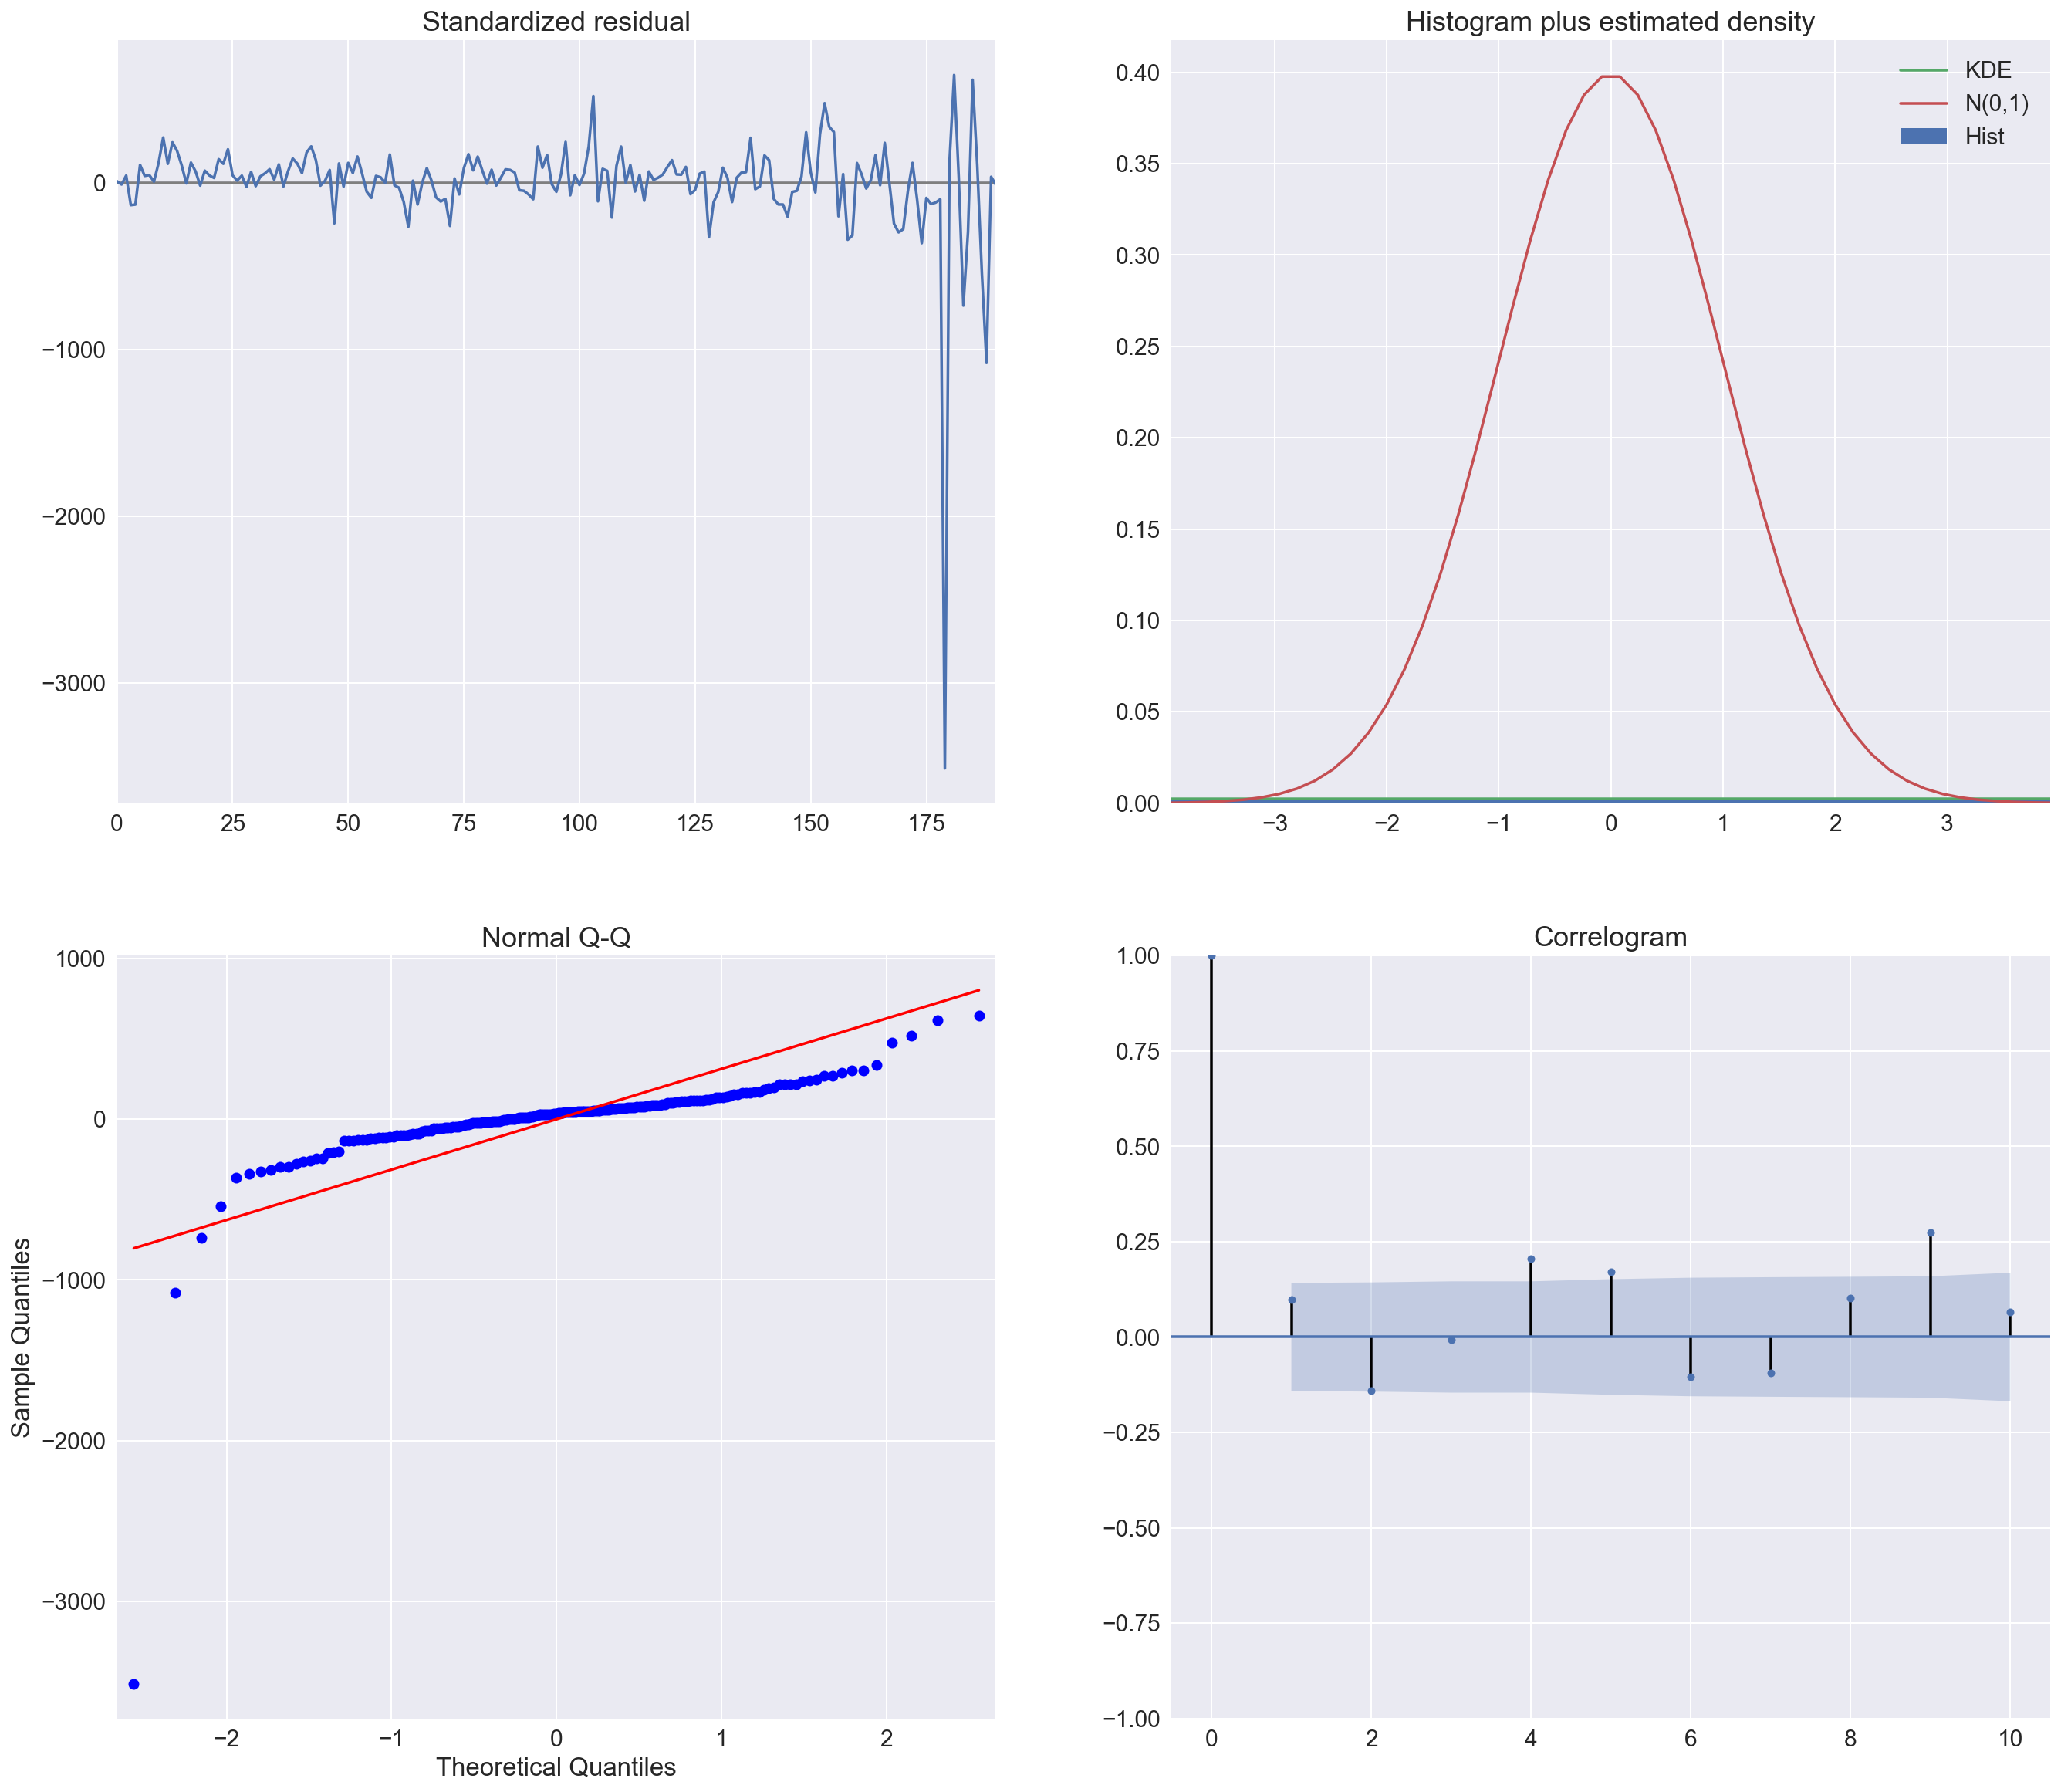

In [161]:
results.plot_diagnostics(0,figsize=(20,20));

### Observing Model Accuracy

In [17]:
predictions = pd.DataFrame(results.predict(),columns=df_2017_1.columns)
predictions.set_index(df_2017_1.index,inplace=True)

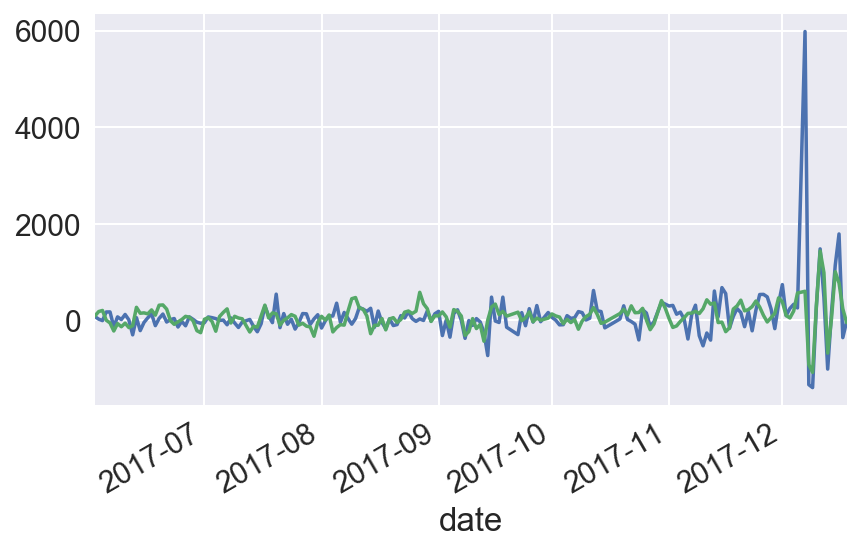

In [18]:
fig, ax = plt.subplots()
df_2017_1.price.plot(ax=ax)
predictions.price.plot(ax=ax)

In [19]:
r2_score(df_2017_1.price, predictions.price)

0.22918163603632336

In [23]:
model = sm.tsa.VARMAX(df_2017_1.loc[:,:].values, order=(5,2),trend='c',enforce_stationarity=True)
results = model.fit(maxiter=5000,method='powell')

Optimization terminated successfully.
         Current function value: 5.867031
         Iterations: 23
         Function evaluations: 53208


In [24]:
r2_score(df_2017_1.price, predictions.price)

0.22918163603632336

In [25]:
df_2017_1

polarity  subjectivity  favorites  retweets    price
date                                                            
2017-06-02  0.101532      0.216899   1.680301  1.246502    80.67
2017-06-03  0.055900      0.223269   2.262570  1.646182    26.80
2017-06-04  0.052062      0.191258   1.059172  4.359763    -3.54
2017-06-05  0.069044      0.183878   1.887861  2.910983   175.00
2017-06-06  0.077932      0.264108   1.515263  1.301587   176.39
2017-06-07  0.075822      0.220866   1.876161  1.068111  -131.04
2017-06-08  0.050610      0.192627   1.739890  1.139706    73.46
2017-06-09  0.069650      0.234044   1.332258  1.138710    18.19
2017-06-10  0.109252      0.238157   1.185027  0.873797   123.90
2017-06-11  0.062037      0.190254   2.645989  1.878075    10.40
2017-06-12  0.063913      0.204394   4.260000  1.771111  -298.48
2017-06-13  0.067062      0.203109   2.058350  1.668008    57.39
2017-06-14  0.067249      0.207635   5.137744  1.687636  -210.65
2017-06-15  0.061461      0.255965   1.815047  0.849530   -41.79
2017-06-16  0.055173      0.224391   2.374359  2.156410    53.98
2017-06-17  0.068331      0.220190   1.824507  1.835929   137.32
2017-06-18  0.078848      0.212334   1.536683  1.120603  -107.59
2017-06-19  0.041680      0.217683   0.754293  0.529723    41.31
2017-06-20  0.055776      0.171593   1.234857  0.757705   132.19
2017-06-21  0.058413      0.208281   2.556180  2.380150   -32.69
2017-06-22  0.052064      0.189698   1.365457  0.948686    16.31
2017-06-23  0.061807      0.191804   2.032787  1.460656    39.50
2017-06-24  0.061446      0.200549   1.062299  0.663802  -136.19
2017-06-25  0.060091      0.205761   3.715615  0.767322   -19.31
2017-06-26  0.046581      0.212196   1.818059  1.553908  -110.96
2017-06-27  0.030644      0.194272   2.056237  1.938650    74.00
2017-06-28  0.064521      0.290363   2.339492  3.197460    22.34
2017-06-29  0.055311      0.194796   1.338858  4.834254   -35.47
2017-06-30  0.063024      0.265521   1.174512  0.701493   -58.48
2017-07-01  0.008227      0.299281   0.732832  0.588899   -46.29
...              ...           ...        ...       ...      ...
2017-11-18  0.073986      0.266503   1.285383  1.113689    81.16
2017-11-19  0.082750      0.246984   6.113490  2.951820   246.34
2017-11-20  0.079687      0.248362   2.408435  1.287458   164.15
2017-11-21  0.055244      0.215131   1.992600  1.065539  -129.38
2017-11-22  0.084760      0.232305   2.007973  0.851936   182.29
2017-11-23  0.068949      0.239076   1.929360  1.241722  -214.78
2017-11-24  0.067141      0.221576   2.263844  2.009772   214.92
2017-11-25  0.082431      0.237879   2.607650  2.180328   537.23
2017-11-26  0.073761      0.241080   1.832623  0.868870   539.63
2017-11-27  0.131191      0.305323   3.931106  1.389353   487.80
2017-11-28  0.059341      0.244479   1.523344  1.362649   240.45
2017-11-29  0.054803      0.225971   1.824435  0.702259  -170.19
2017-11-30  0.057441      0.244585   8.896008  4.510504   344.99
2017-12-01  0.053308      0.217243   2.322615  0.832797   742.00
2017-12-02  0.064013      0.234665   1.455328  0.814855    99.00
2017-12-03  0.089537      0.257589   2.336100  0.797718   248.60
2017-12-04  0.080994      0.224581   2.266304  1.241304   334.00
2017-12-05  0.066022      0.251876   1.593617  0.558511   259.50
2017-12-07  0.059191      0.268980   2.570842  1.695072  5983.00
2017-12-08  0.057598      0.272820   2.291232  0.728601 -1330.30
2017-12-09  0.089941      0.297408   2.582983  1.363445 -1391.20
2017-12-10  0.072506      0.232075   1.946612  0.685832   277.20
2017-12-11  0.057313      0.269100   2.153277  0.492600  1481.40
2017-12-12  0.039895      0.277412  10.000000  2.973085   478.60
2017-12-13  0.090507      0.281799   1.565539  0.641649 -1007.20
2017-12-14  0.053300      0.261810   2.429171  1.287513   155.80
2017-12-15  0.057968      0.217999   3.305120  1.413793  1142.90
2017-12-16  0.063293      0.210049   3.077731  0.886555  1790.50
2017-12-17  0.057661      0.228947   2.367925  

### Ignoring large volatility section

By cutting off the final section, model accuracy improves slightly - but is still very low at only at 4.8%

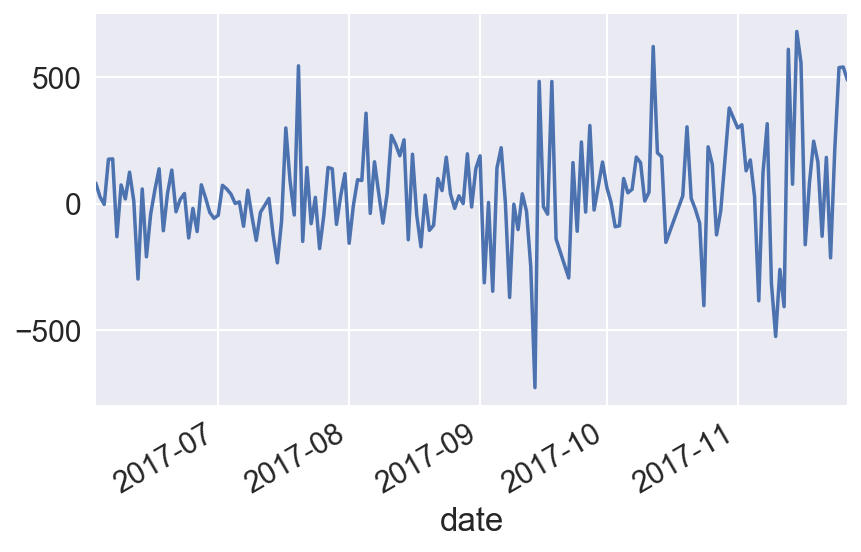

In [32]:
fig, ax = plt.subplots()
df_2017_1.price[:-20].plot(ax=ax)

In [20]:
model_2 = sm.tsa.VARMAX(df_2017_1[:-20].values, order=(5,1),trend='c',enforce_stationarity=True)
results_2 = model_2.fit(maxiter=5000,method='powell')

predictions_2 = pd.DataFrame(results_2.predict(),columns=df_2017_1.columns)
predictions_2.set_index(df_2017_1[:-20].index,inplace=True)

Optimization terminated successfully.
         Current function value: 5.006413
         Iterations: 15
         Function evaluations: 28813


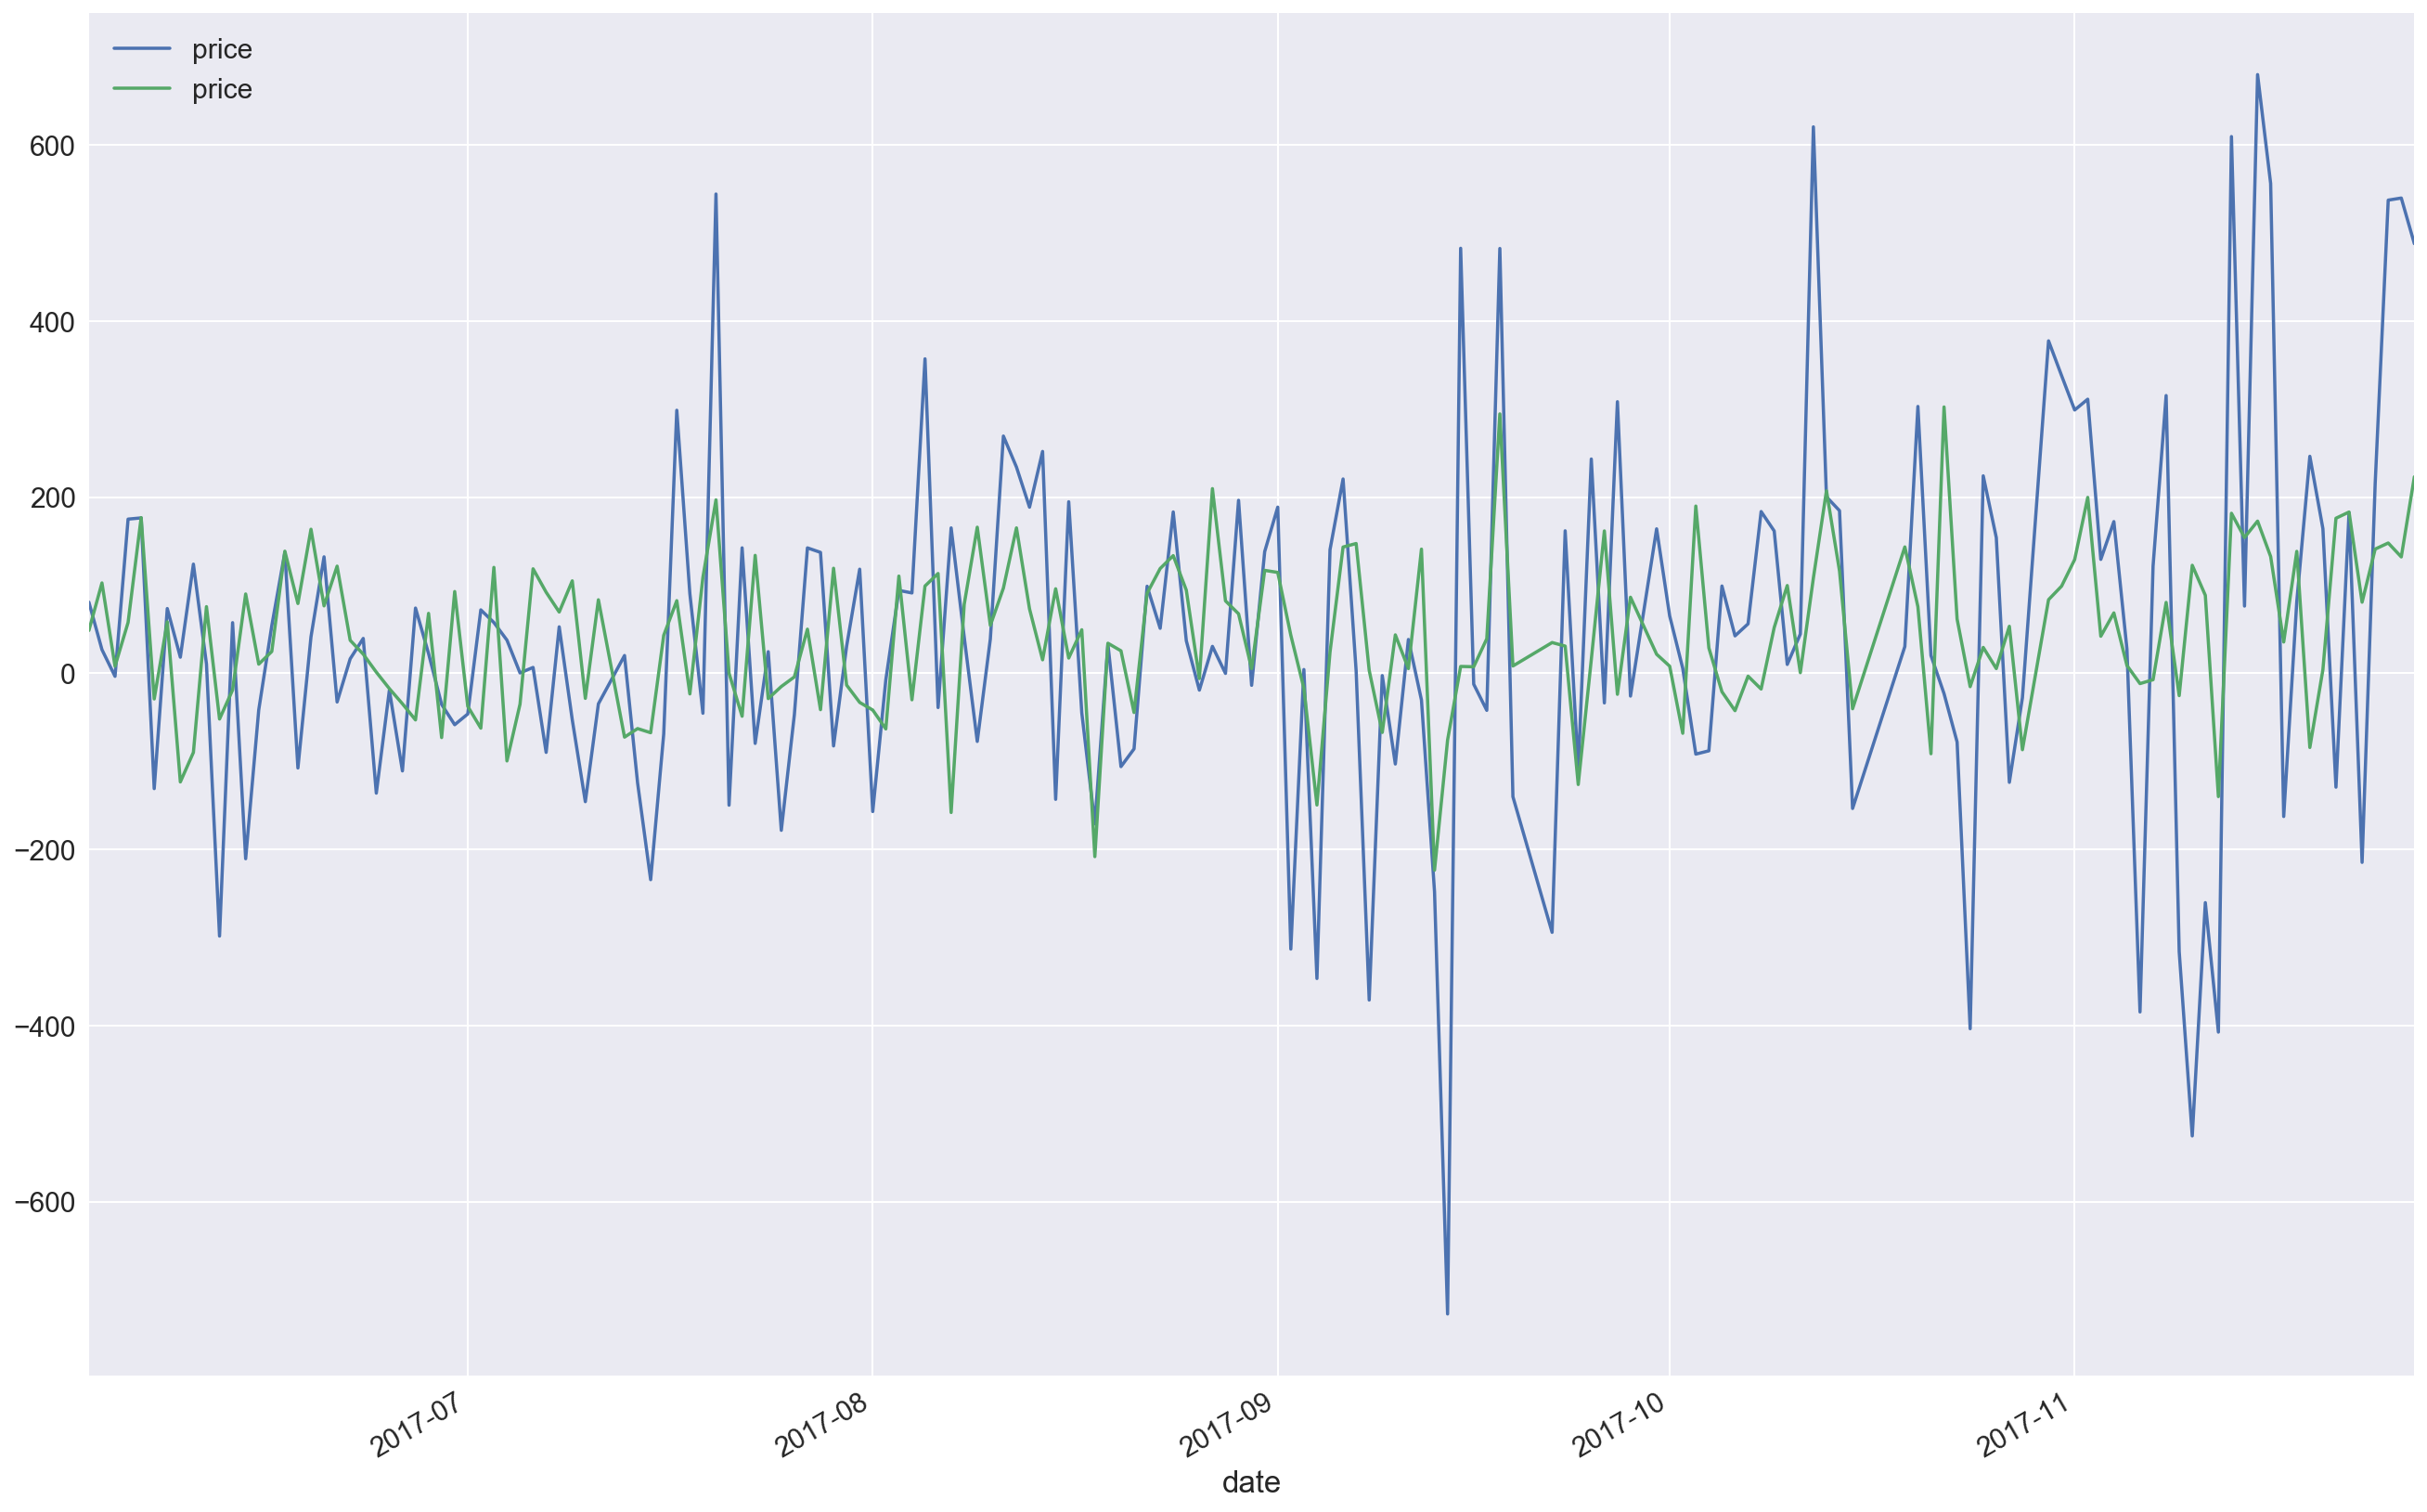

In [21]:
fig, ax = plt.subplots(figsize=(20,15))
df_2017_1.price[:-20].plot(ax=ax, legend=True)
predictions_2.price.plot(ax=ax, legend=True)

In [22]:
r2_score(df_2017_1.price[:-20], predictions_2.price)

0.15646011913687485

### Gridsearch

Searching through model parameters allows optimisation of the model. Using the following parameters, the r2 score was increased from 0.2 to 0.45. It seems the higher my parameters, the better the result. The best result was q:9 p:3 - but it was also the highest combination tried. Computing more complex models require high computation power. This would be a viable cost if it improves the accuracy of the model, as it could lead to profiting from the results. Having too high of parameters could also lead to overfitting the model - but this amount should not be an issue as it is a small amount of the data.

The q9,p3 model gave 44.8% R2 results, a much better value than the previous model.

In [ ]:
for p in [1,3,5]:
    for q in [1,3,5,7,9]:
        model = sm.tsa.VARMAX(df_2017_1.loc[:,:].values, order=(q,p),trend='c',enforce_stationarity=True)
        results = model.fit(maxiter=5000,method='powell')

        predictions = pd.DataFrame(results.predict(),columns=df_2017_1.columns)
        predictions.set_index(df_2017_1.index,inplace=True)
        print 'q:', q, 'p:', p
        print r2_score(df_2017_1.price, predictions.price)

Optimization terminated successfully.
         Current function value: 6.291794
         Iterations: 11
         Function evaluations: 8358
q: 1 p: 1
0.0405194654728
Optimization terminated successfully.
         Current function value: 6.141552
         Iterations: 6
         Function evaluations: 8159
q: 3 p: 1
0.122063825681
Optimization terminated successfully.
         Current function value: 5.924252
         Iterations: 17
         Function evaluations: 32952
q: 5 p: 1
0.229181636036
Optimization terminated successfully.
         Current function value: 5.728978
         Iterations: 7
         Function evaluations: 19032
q: 7 p: 1
0.344654449888
Optimization terminated successfully.
         Current function value: 5.583397
         Iterations: 11
         Function evaluations: 37815
q: 9 p: 1
0.433954846237
Optimization terminated successfully.
         Current function value: 6.135189
         Iterations: 28
         Function evaluations: 39010
q: 1 p: 3
0.105534751104
Optimiz

In [14]:
model = sm.tsa.VARMAX(df_2017_1.loc[:,:].values, order=(9,3),trend='c',enforce_stationarity=True)
results = model.fit(maxiter=5000,method='powell')

predictions = pd.DataFrame(results.predict(),columns=df_2017_1.columns)
predictions.set_index(df_2017_1.index,inplace=True)
print 'q:', q, 'p:', p
print r2_score(df_2017_1.price, predictions.price)

KeyboardInterrupt: 

In [29]:
df = pd.read_csv('BTC_updated')
df.set_index(pd.DatetimeIndex(df['date']),inplace=True)
six_month_filter = datetime.datetime.now() - relativedelta(months = 6)
df = df.loc[six_month_filter:]

df_base = df.copy()

df['price'] = df['price'].diff()
df = df[1:]

df.drop('date',axis=1,inplace=True)

model = sm.tsa.VARMAX(df.values, order=(9,3),trend='c',enforce_stationarity=True)
results = model.fit(maxiter=5000,method='powell')

Optimization terminated successfully.
         Current function value: 5.725941
         Iterations: 45
         Function evaluations: 192336


In [39]:
df_base[1:]

polarity  subjectivity  favorites   retweets     price
date                                                              
2017-07-24  0.044319      0.207669   1.675505   1.481061   2754.86
2017-07-25  0.078013      0.235997   3.585987   5.665605   2576.48
2017-07-26  0.036566      0.209471   0.861856   0.495876   2529.45
2017-07-27  0.040289      0.212663   3.041489   3.175532   2671.78
2017-07-28  0.024599      0.228457   0.924009   0.439427   2809.01
2017-07-29  0.047969      0.238304   1.991407   1.055854   2726.45
2017-07-30  0.065125      0.228273   1.027532   0.785644   2757.18
2017-07-31  0.063845      0.216514   0.917981   0.477918   2875.34
2017-08-01  0.038017      0.152263   6.184120   6.941312   2718.26
2017-08-02  0.032686      0.232590   1.454427   0.850260   2710.67
2017-08-03  0.062943      0.192107  10.000000  10.000000   2804.73
2017-08-04  0.040986      0.218577   1.060209   1.092932   2895.89
2017-08-05  0.062367      0.212633   1.669927   1.297066   3252.91
2017-08-06  0.073265      0.224264  10.000000  10.000000   3213.94
2017-08-07  0.074638      0.250031   5.692094   2.563107   3378.94
2017-08-08  0.076471      0.204677   1.215402   0.597098   3419.94
2017-08-09  0.037938      0.239464   1.076246   1.298143   3342.47
2017-08-10  0.068842      0.224318   0.960000   0.637895   3381.28
2017-08-11  0.066875      0.228800   1.975059   2.486936   3650.62
2017-08-12  0.077142      0.233930   2.735867   2.247563   3884.71
2017-08-13  0.063820      0.220820   2.605617   6.757021   4073.26
2017-08-14  0.040140      0.228698   1.732913   1.125131   4325.13
2017-08-15  0.070888      0.216780   2.338159   1.336091   4181.93
2017-08-16  0.077304      0.211178   1.473242   1.035677   4376.63
2017-08-17  0.070050      0.228305   3.508108   2.782703   4331.69
2017-08-18  0.069356      0.242768   1.786725   1.697497   4160.62
2017-08-19  0.067313      0.240331   2.439055   1.766169   4193.70
2017-08-20  0.055857      0.184187   5.081505   5.623824   4087.66
2017-08-21  0.044144      0.223370   2.988688   2.549774   4001.74
2017-08-22  0.048466      0.193686   6.660047   1.193925   4100.52
...              ...           ...        ...        ...       ...
2017-12-22  0.065060      0.266230   2.970085   0.555556  13664.97
2017-12-23  0.059594      0.252218   2.412698   0.549206  14396.46
2017-12-24  0.060895      0.247640   4.691569   1.189968  13789.95
2017-12-25  0.072221      0.238890   2.235919   1.012752  13833.49
2017-12-26  0.058536      0.257096   2.682796   0.929032  15756.56
2017-12-27  0.061563      0.241042   2.653968   1.488889  15416.64
2017-12-28  0.072059      0.252360   1.648971   0.641387  14398.70
2017-12-29  0.074405      0.231646   2.174054   1.105946  14392.57
2017-12-30  0.073264      0.231690   1.868108   0.729730  12531.52
2017-12-31  0.097534      0.230426   1.493534   0.526940  13850.40
2018-01-01  0.058711      0.240500   2.431940   1.255091  13444.88
2018-01-02  0.073203      0.263973   3.509595   1.893390  14754.13
2018-01-03  0.079779      0.258902   3.455497   0.790576  15156.62
2018-01-04  0.073353      0.260363   2.505400   0.615551  15180.08
2018-01-05  0.083746      0.255680   3.160042   1.381799  16954.78
2018-01-06  0.084222      0.252485   1.881210   0.485961  17172.30
2018-01-07  0.077171      0.246061   2.740302   1.357759  16228.16
2018-01-08  0.062431      0.232757   1.747346   0.848195  14976.17
2018-01-09  0.066195      0.227477   3.194942   0.985248  14468.50
2018-01-10  0.037720      0.257560   1.515575   0.491944  14919.49
2018-01-11  0.078686      0.265999   4.584375   1.817708  13308.06
2018-01-12  0.062728      0.259316   3.269274   1.081564  13841.19
2018-01-13  0.067889      0.251861   3.016340   1.123094  14243.12
2018-01-14  0.077320      0.256919   3.334778   1.653304  13638.63
2018-01-15  0.083375      0.240930   2.723699   2.261272  13631.98
2018-01-16  0.038107      0.228175   2.265690   0.661088  11282.49
2018-01-17  0.074500      0.228051   3.583247   1.586350  1

In [41]:
predictions = pd.DataFrame(results.predict(),columns=df_base[1:].columns)
predictions.set_index(df_base[1:].index,inplace=True)

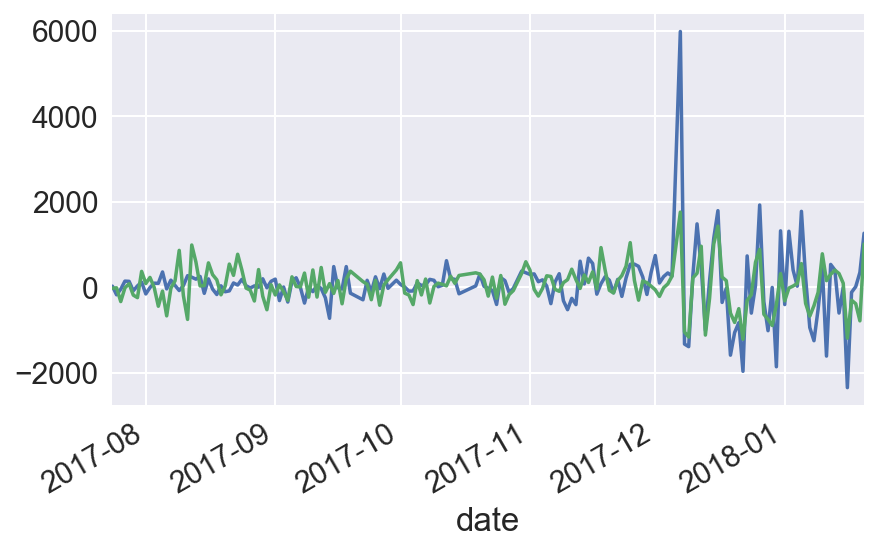

In [43]:
fig, ax = plt.subplots()
df.price.plot(ax=ax)
predictions.price.plot(ax=ax)

In [44]:
r2_score(df.price, predictions.price)

0.37042075609926828

In [45]:
one_day_forecast = results.forecast(steps=1)

In [46]:
df_base.iloc[-1,4] + one_day_forecast[0][4]

12760.966513526824

In [ ]:
Is the model profitable?

AttributeError: 'DataFrame' object has no attribute 'summary'

In [53]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     ['y1', 'y2', 'y3', 'y4', 'y5']   No. Observations:                  173
Model:                                 VARMA(9,3)   Log Likelihood                -990.588
                                      + intercept   AIC                           2621.176
Date:                            Mon, 22 Jan 2018   BIC                           3630.229
Time:                                    19:09:55   HQIC                          3030.542
Sample:                                         0                                         
                                            - 173                                         
Covariance Type:                              opg                                         
===========================================================================================================================
Ljung-Box (Q):          25.19, 26.46, 26.41, 25.59, 24.29   Jarque-Bera (JB):   1866.36, 2339.75, 2155.08, 1908.98, 1747.88
Prob(Q):                     0.97, 0.95, 0.95, 0.96, 0.98   Prob(JB):                          0.00, 0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H):      5.24, 8.01, 6.59, 5.49, 4.77   Skew:                           -2.11, -2.31, -2.22, 2.11, 2.06
Prob(H) (two-sided):         0.00, 0.00, 0.00, 0.00, 0.00   Kurtosis:                     18.53, 20.41, 19.71, 18.72, 18.02
                           Results for equation y1                            
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0336      0.066      0.512      0.609      -0.095       0.162
L1.y1         -0.0670      0.134     -0.499      0.618      -0.330       0.196
L1.y2         -0.0943      0.138     -0.682      0.495      -0.365       0.177
L1.y3         -0.0025      0.013     -0.189      0.850      -0.028       0.023
L1.y4         -0.0008      0.009     -0.095      0.925      -0.018       0.017
L1.y5       -2.28e-06   2.57e-05     -0.089      0.929   -5.26e-05    4.81e-05
L2.y1          0.0817      0.223      0.366      0.715      -0.356       0.520
L2.y2          0.0836      0.130      0.641      0.522      -0.172       0.339
L2.y3          0.0040      0.010      0.383      0.702      -0.016       0.024
L2.y4         -0.0009      0.010     -0.094      0.925      -0.020       0.018
L2.y5       5.005e-06   3.59e-05      0.140      0.889   -6.53e-05    7.53e-05
L3.y1          0.1672      0.117      1.428      0.153      -0.062       0.397
L3.y2          0.0162      0.142      0.114      0.909      -0.262       0.295
L3.y3      -6.196e-05      0.010     -0.006      0.995      -0.020       0.020
L3.y4          0.0005      0.009      0.050      0.960      -0.017       0.018
L3.y5       3.515e-06   3.81e-05      0.092      0.926   -7.11e-05    7.81e-05
L4.y1          0.1469      0.237      0.619      0.536      -0.318       0.612
L4.y2          0.0182      0.170      0.107      0.915      -0.316       0.352
L4.y3          0.0011      0.004      0.274      0.784      -0.007       0.009
L4.y4         -0.0002      0.004     -0.045      0.964      -0.008       0.008
L4.y5      -3.176e-06   1.48e-05     -0.215      0.830   -3.21e-05    2.58e-05
L5.y1         -0.0262      0.216     -0.122      0.903      -0.449       0.397
L5.y2         -0.0555      0.181     -0.306      0.759      -0.411       0.300
L5.y3         -0.0014      0.006     -0.211      0.833      -0.014       0.011
L5.y4          0.0012      0.005      0.270      0.787      -0.008       0.010
L5.y5       2.174e-06   1.15e-05      0.188      0.851   -2.05e-05    2.48e-05
L6.y1          0.0913      0.220      0.415      0.6

### Can the change predict rises and falls - regardless of magnitude?

Making the only predict rise and falls makes the results even less accurate, with an r2 score of -91%...

In [68]:
df_2017_rise = df_2017_1.copy() 
df_2017_rise['change'] = df_2017_rise['price'].map(lambda x: 1 if x >=0 else 0)

In [69]:
predictions_2_rise = predictions_2.copy()
predictions_2_rise['diff'] = predictions_2_rise['price'].diff()
predictions_2_rise['change'] = predictions_2_rise['diff'].map(lambda x: 1 if x >=0 else 0)

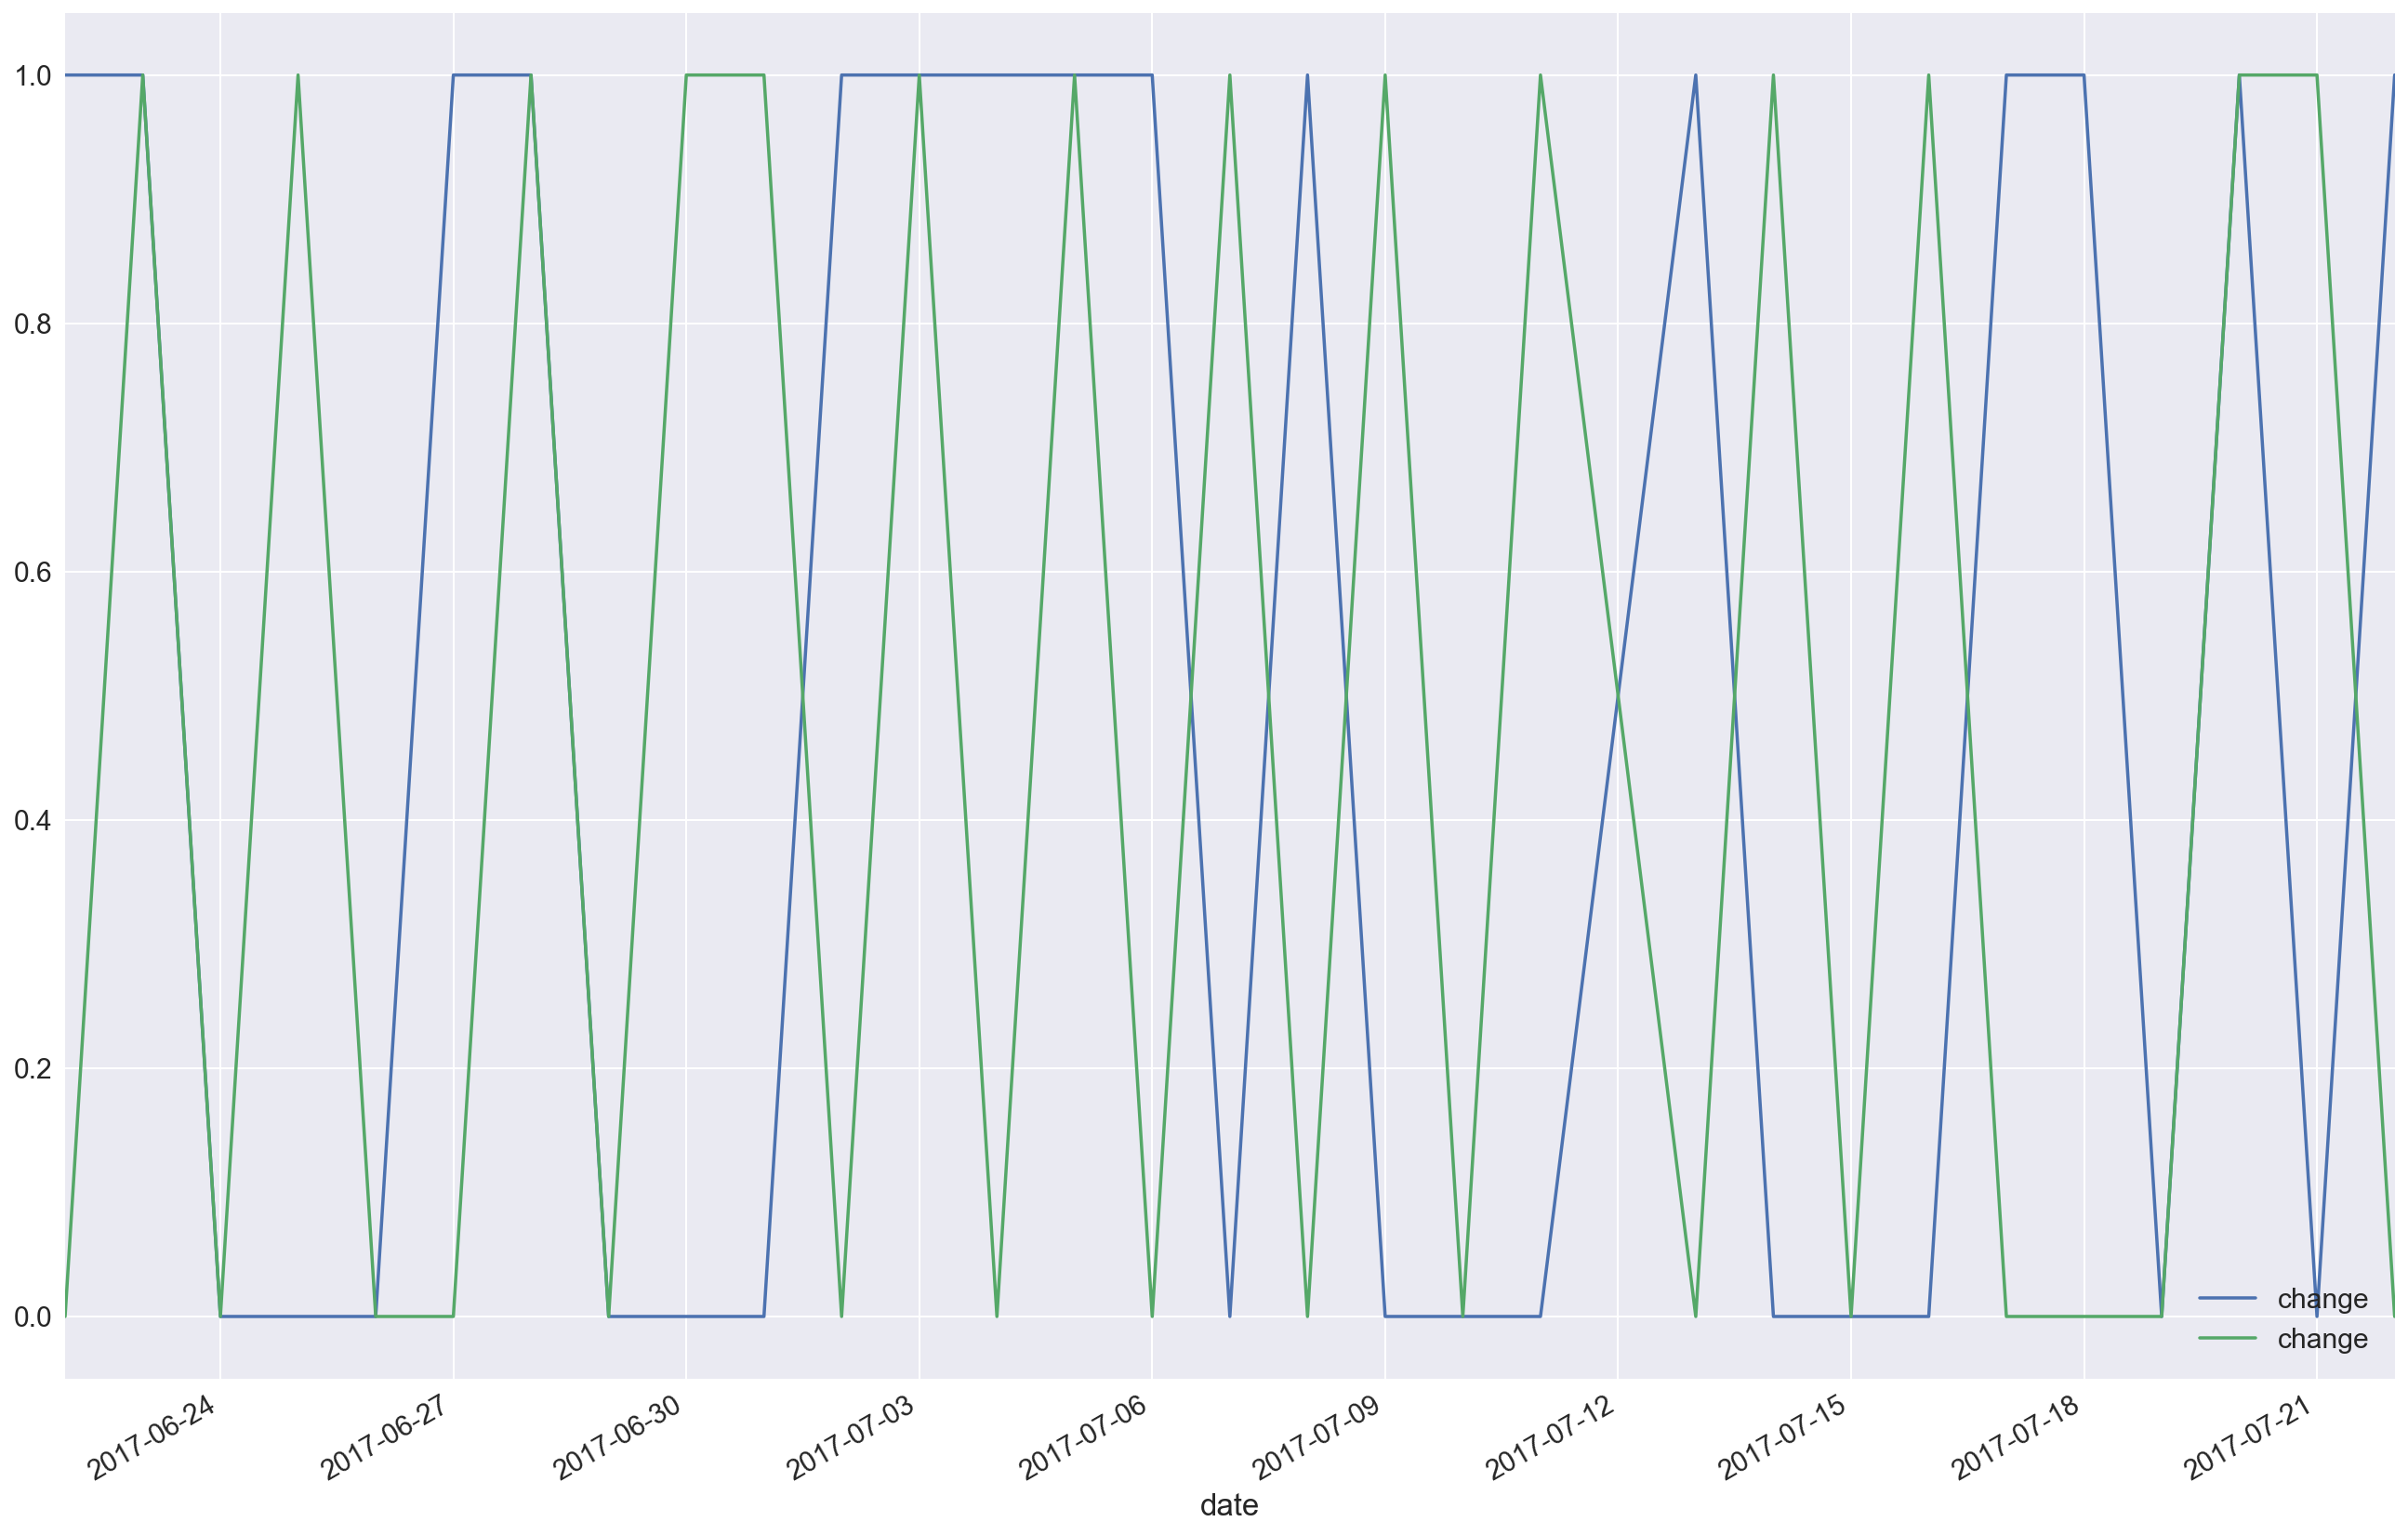

In [73]:
fig, ax = plt.subplots(figsize=(20,15))
df_2017_rise.change[:-20][20:50].plot(ax=ax, legend=True)
predictions_2_rise.change[20:50].plot(ax=ax, legend=True)

In [71]:
r2_score(df_2017_rise.change[:-20], predictions_2_rise.change)

-0.91943734015345258

In [ ]:
#use accuracy score?

### TODO - How does the Twitter Model compare to simply modelling the price?

In [47]:
ar1c = ARMA(df_2017_1.iloc[:,4], (9, 1)).fit(method='mle',ic='AIC',
                               trend='c')
ar1c.summary2() 

/Users/matthias/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: ARMA
====================================================================
Model:              ARMA             BIC:                 2964.2302 
Dependent Variable: price            Log-Likelihood:      -1450.6   
Date:               2018-01-22 19:08 Scale:               1.0000    
No. Observations:   191              Method:              mle       
Df Model:           11               Sample:              06-02-2017
Df Residuals:       180                                   12-18-2017
Converged:          0.0000           S.D. of innovations: 478.870   
AIC:                2925.2030        HQIC:                2941.011  
---------------------------------------------------------------------
               Coef.    Std.Err.     t     P>|t|    [0.025    0.975] 
---------------------------------------------------------------------
const         132.0191  105.6528   1.2496  0.2131  -75.0565  339.0948
ar.L1.price     0.5813    0.1437   4.0452  0.0001    0.2997    0.8630
ar.L2.price    -0.0811    0.0825  -0.9834  0.3267   -0.2428    0.0805
ar.L3.price     0.1273    0.0866   1.4693  0.1435   -0.0425    0.2971
ar.L4.price     0.1432    0.0830   1.7259  0.0861   -0.0194    0.3059
ar.L5.price     0.0663    0.0852   0.7779  0.4376   -0.1007    0.2334
ar.L6.price    -0.1695    0.0887  -1.9116  0.0575   -0.3433    0.0043
ar.L7.price    -0.0263    0.0842  -0.3130  0.7546   -0.1913    0.1386
ar.L8.price     0.1031    0.0842   1.2250  0.2222   -0.0619    0.2682
ar.L9.price     0.1773    0.0836   2.1205  0.0353    0.0134    0.3411
ma.L1.price    -0.7429    0.1349  -5.5080  0.0000   -1.0073   -0.4786
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            1.0250            -0.0000           1.0250            -0.0000
AR.2            0.9662            -0.6513           1.1652            -0.0944
AR.3            0.9662             0.6513           1.1652             0.0944
AR.4            0.1800            -1.0777           1.0927            -0.2237
AR.5            0.1800             1.0777           1.0927             0.2237
AR.6           -0.7025            -1.1655           1.3608            -0.3363
AR.7           -0.7025             1.1655           1.3608             0.3363
AR.8           -1.2471            -0.5273           1.3541            -0.4363
AR.9           -1.2471             0.5273           1.3541             0.4363
MA.1            1.3460             0.0000           1.3460             0.0000
====================================================================

"""

In [48]:
print 'MSE sklearn:\t\t', mean_squared_error(df_2017_1.iloc[:,4], ar1c.fittedvalues)
print 'MSE statsmodels:\t', ar1c.sigma2
print 'R2 Score:\t\t', r2_score(df_2017_1.iloc[:,4], ar1c.fittedvalues)

MSE sklearn:		229416.820115
MSE statsmodels:	229316.893106
R2 Score:		0.207125902122


What about taking out the last few volatile prices?

In [27]:
##PREDICTION

#Play with adjusting the arma parameters
#maybe other models are better at handling variance 
#Try Arima
#check bayesian modeling for distributions

# Building Price Scraper for post 18-12-2017 Tweets

In [16]:
def crypto_updater(symbol, currency_name, tweets_per_day):
    def daterange(start_date, end_date):
        for n in range(int ((end_date - start_date + timedelta(1)).days)):
            yield start_date + timedelta(n)
    
    
    #Querry price API over daterange
    date_list = []
    price_list = []
    current_time = date(datetime.datetime.now().year, datetime.datetime.now().month, datetime.datetime.now().day)
    date_range = daterange(date(2017,12,19), current_time)
    for n in date_range:

        year = str(n.year)
        month = str(n.month)
        if len(month) == 1:
            month = '0'+month
        day = str(n.day)
        if len(day) == 1:
            day = '0' + day
        date_list.append(year + '-' + month + '-' + day)

        epoch =  time.mktime(n.timetuple())
        url = 'https://min-api.cryptocompare.com/data/pricehistorical?fsym='
        full_url = url + symbol + '&tsyms=BTC,USD&ts=' + str(epoch) + '&extraParams=your_app_name'
        r = requests.get(full_url).json()
        price =  r[symbol]['USD']
        price_list.append(price)
        
    df_new = pd.DataFrame()
    df_new['date'] = date_list
    df_new['close'] = price_list
    df_new['symbol'] = symbol

    crypto_tweet_scraper_s3(symbol, currency_name, tweets_per_day, start_date = date(2017,12,18), verbose=1)
    crypto_df = tweet_loader(symbol, tweets_per_day)
    crypto_df = crypto_df[(crypto_df['date'].str.contains('2017-12')) | (crypto_df['date'].str.contains('2018'))]
    clean_df = clean_raw_data(crypto_df, symbol, df_new, tweets_per_day)


    #Merge old data - change later to more loadable version
    c_df = pd.read_csv('cleaned_data_2017-01-13').set_index('date')

    df_2017 = c_df[c_df.index.str.contains('2017')]

    #concatenate old and new DFs
    merged_df = pd.concat([df_2017, clean_df]).drop_duplicates()
    merged_df.to_csv(symbol + '_updated')
    return merged_df
        

TODO: Change function so that it tries to load symbol_updated file which is the dataframe.
this should be my latest file of the crypto I'm dealing with. I don't hav to do this now as I'm only dealing with crypto, but will have to change to deal with other currencies.

Make it so that it it only querries api starting on the last date in my current DF

In [23]:
test = crypto_updater('BTC','bitcoin',1000)

In [25]:
test.to_csv('BTC' + '_updated')

# Outputting the pricing prediction for the next day

Build a function modeller, then build an outputting function that updates DF, makes a model, and outputs next day price

In [26]:
def predictor(df):

    df.set_index(pd.DatetimeIndex(df['date']),inplace=True)
    six_month_filter = datetime.datetime.now() - relativedelta(months = 6)
    df = df.loc[six_month_filter:]

    df_base = df.copy()

    df['price'] = df['price'].diff()
    df = df[1:]

    df.drop('date',axis=1,inplace=True)

    model = sm.tsa.VARMAX(df.values, order=(9,3),trend='c',enforce_stationarity=True)
    results = model.fit(maxiter=5000,method='powell')

    one_day_forecast = results.forecast(steps=1)
    return df_base.iloc[-1,5] + one_day_forecast[0][4]

In [386]:
df = pd.read_csv('BTC_updated')
predictor(df)

/Users/matthias/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Optimization terminated successfully.
         Current function value: 6.603280
         Iterations: 21
         Function evaluations: 16043


12991.48442009634